In [21]:
%load_ext autoreload
% autoreload 2
from __future__ import print_function
import argparse
import os, datetime
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
print(torch.__version__)
from geant_dataloader import rtnpy_load_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from torch.autograd import grad
#from logistics import sigmoid_normalize, logistic_unnormalize, tanh_normalize, arctanh_unnormalize
from logistics import *
from matplotlib import gridspec
plt.rc('font', family='serif')
from decimal import Decimal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.4.0a0+200fb22


In [22]:
# NOTE: THIS CODE ASSUMES PYTORCH 0.4 installed (more specifically, it was tested on 0.4.0a0+200fb22)



dataroot = "build/B4_2k.root"
workers = 2
batchSize = 20
imageSize =32
nz = 100
ngf = 64
ndf = 64
nc = 1
niter = 50
lr = 2e-4
beta1 = 0.5
cuda = 'store_true'
netG_path = "output/"
netD_path = "output/"
outf = "output/"
manualSeed = 25
ngpu = 1
mydir=None # will be updated before the run
epoch=0 #will be updated during the run
epochs = []
genx_FWHMs = []
genx_means = []
realx_FWHMs = []
realx_means =  []
extraD = 1

norm_scale = 'unif'

try:
    os.makedirs(outf)
except OSError:
    pass



In [25]:
if manualSeed is None:
    manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

cudnn.benchmark = True
dev_type = 'cpu'
if torch.cuda.is_available():
    print("Using Cuda")
    dev_type = 'gpu'
    
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)
print("Using:", dev_type, torch.cuda.current_device())


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

Random Seed:  25
Using Cuda
cuda:2
Using: gpu 0


In [26]:
# LOAD DATA:

#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/rebinnedGeant4Data_20000Events_64OldSize_32NewSize.npy", image_size = imageSize)
image_array = rtnpy_load_data("numpy_data/geant4Data_30000Events_"+str(imageSize) + "ImageSize_800MeV_ScintiAbsoThickness75_8.npz", image_size = imageSize)
#image_array = rtnpy_load_data("/home/chris/G4Builds/Geant4HadronCalorimeter/numpy_data/geant4Data_15000Events_64ImageSize_800MeV_ScintiAbsoThickness75_8.npy",  image_size = imageSize)
#image_array=np.concatenate((image_array1, image_array2),0)
#print(image_array.shape)

#np.savez_compressed("numpy_data/geant4Data_30000Events_64ImageSize_800MeV_ScintiAbsoThickness75_8.npz", array = image_array)
#image_array = np.load("numpy_data/test.npz")['array']
#print(image_array.shape, image_array_comp.shape)
#plt.imshow(image_array[0][0])
#plt.show()
#plt.imshow(image_array_comp[0][0])
print(image_array.shape)

(30000, 1, 32, 32)


In [27]:
#plt.hist(image_array[0][0][:,0])
# for i in range(image_array.shape[0]):
#     if np.isnan(image_array[i][0]).any():
#         del image_array[i][0]
#print(image_array[~np.isnan(image_array).any(axis=0)])
#print(image_array)
#image_array = np.delete(image_array, 10840, axis = 0)
normed_array, scale = normalize(image_array, norm_scale = norm_scale )
#normed_array, scale = sigmoid_normalize(image_array)
print(image_array.shape)
tensor_array = torch.stack([torch.Tensor(i) for i in normed_array])
tensor_data = torch.utils.data.TensorDataset(tensor_array)
dataloader = torch.utils.data.DataLoader(tensor_data, batch_size=batchSize, num_workers=8)
dataloader

(30000, 1, 32, 32)


In [28]:
if norm_scale == 'unif':
    last_layer = nn.Sigmoid()
else:
    last_layer = nn.Tanh()


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            #nn.Tanh()
            last_layer
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


class Generator32(nn.Module):
    def __init__(self, ngpu):
        super(Generator32, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            #inc, outc, kernel, stride, padding, output padding
#             nn.ConvTranspose2d(     nz, 32 * 8, 2, 1, 0, bias=False),
#             nn.BatchNorm2d(32 * 8),
#             nn.ReLU(True),
#             # state size. (ngf*8) x 2 x 2
#             nn.ConvTranspose2d(32 * 8, 32 * 4, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 4),
#             nn.ReLU(True),
#             # state size. (ngf*4) x 4 x 4
#             nn.ConvTranspose2d(32 * 4, 32 * 2, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 2),
#             nn.ReLU(True),
#             # state size. (ngf*2) x 8 x 8
#             nn.ConvTranspose2d(32 * 2,     32, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32),
#             nn.ReLU(True),
#             # state size. (ngf) x 16 x 16
#             nn.ConvTranspose2d(    32,      nc, 2, 2, 0, bias=False),
#             last_layer
#             # state size. (nc) x 64 x 64
            
            nn.ConvTranspose2d(     nz, 32 * 8, 2, 1, 0, bias=False),
            nn.BatchNorm2d(32 * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 2 x 2
            nn.ConvTranspose2d(32 * 8, 32 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(32 * 4, 32 * 2, 5, 1, 0, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(32 * 2,     32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(    32,      nc, 4, 2, 0, bias=False),
            last_layer
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output
    
    
if imageSize == 32:
    netG = Generator32(ngpu).to(device)
else:
    netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            # kernel size = 4 (so I image 4 x 4 x 1)
            # stride = 2, 
            # padding = 1
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)
    
class Discriminator32(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator32, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            # kernel size = 4 (so kernel filter 4 x 4 x 1)
            # stride = 2, 
            # padding = 0
#             nn.Conv2d(nc, 32, 2, 2, 0, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf) x 16 x 16
#             nn.Conv2d(32, 32 * 2, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 2),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*2) x 8 x 8
#             nn.Conv2d(32 * 2, 32 * 4, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 4),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*4) x 4 x 4
#             nn.Conv2d(32 * 4, 32 * 8, 2, 2, 0, bias=False),
#             nn.BatchNorm2d(32 * 8),
#             nn.LeakyReLU(0.2, inplace=True),
#             # state size. (ndf*8) x 2 x 2
#             nn.Conv2d(32 * 8, 1, 2, 2, 0, bias=False),
#             nn.Sigmoid()
            nn.Conv2d(nc, ndf, 5, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 5, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 2, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 3, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

if imageSize == 32:
    netD = Discriminator32(ngpu).to(device)
else:
    netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#if opt.netD != '':
#    netD.load_state_dict(torch.load(opt.netD))
print(netD)
#if netG != '':
#    netG.load_state_dict(torch.load(netG))
#print(netG)

Generator32(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (13): Sigmoid()
  )
)
Discriminator32(
  (main): Sequential(
    (0): Co

In [34]:
def make_samples(netG, n_events=500, real=True, fake = True, avg = True ):

    #test_image = 0#fake.to('cpu').detach().numpy()[0][0]
    fake_image = 0 #arctanh_unnormalize(test_image, scale)
    real_image = 0
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image += image_array[idx][0]
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake_output = netG(noise)
        gen_image = fake_output.to('cpu').detach().numpy()[0][0]
        fake_image +=  unnormalize(gen_image, scale, norm_scale = norm_scale)
        #fake_image += logistic_unnormalize(test_image, scale)
    if avg == True:
        fake_image = fake_image / n_events
        real_image = real_image / n_events

    #test_noNans = np.copy(test_unnormed)
    #test_unnormed[test_unnormed < 0.0] = np.nan
    if real == True and fake == True:
        return [real_image,fake_image], n_events
    elif (real == False) and (fake == True):
        return fake_image, n_events
    else:
        return real_image, n_events
    
    
    

def make_stacked_samples(netG, n_events, real=False, fake=True):
    fake_images = []
    real_images = []
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image = image_array[idx][0]
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake_output = netG(noise)
        fake_image = fake_output.to('cpu').detach().numpy()[0][0]
        fake_image = unnormalize(fake_image,scale, norm_scale=norm_scale)
        fake_images.append(fake_image)
        real_images.append(real_image)
        
    fake_images_array = np.dstack(fake_images).T
    real_images_array = np.dstack(real_images).T
    if real == True and fake == True:
        return real_images_array,fake_images_array
    elif (real == False) and (fake == True):
        return fake_images_array
    else:
        return real_images_array


def plot_avg(data, n_events, withMarginals=True, save_dir = mydir, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr):

    test_noNans = np.copy(data)
    test_unnormed = data
    test_unnormed[test_unnormed < 0.0] = np.nan
    
    fig=plt.figure(figsize=(6, 6))
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()
    
    if withMarginals == False:
        plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
        cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        if save_dir != None:
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/Geant4/SingleLayerEGun/AverageImage/"
            filename = "DCGAN_AvgEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                        + "Image_Epochs" + str(epoch) + "_" + str(batchSize) + "batchSize_" +  str(lr) + "lr"
            plt.savefig(directory + filename)
        
    else:
        marginals_str = 'withMarginals'
        img=test_noNans
        t = np.arange(-50,50, 100/float(imageSize))
        #t = np.arange(img.shape[0])
        f = np.arange(-50,50, 100/float(imageSize))
        #f = np.arange(img.shape[1])
        flim = (f.min(), f.max())
        tlim = (t.min(), t.max())

        gs = gridspec.GridSpec(2, 2, width_ratios=[1,5], height_ratios=[1,5])
        gs.update(hspace=0, wspace=0)

        ax = fig.add_subplot(gs[1,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent = extent, origin = 'lower', cmap = cmap)
        cbaxes = fig.add_axes([0.97, 0.18, 0.03, 0.55]) 
        cbar = plt.colorbar(mappable=im, ticks = None, cax=cbaxes, use_gridspec=True)
        ax.yaxis.set_ticks_position('right')
        cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        ax.spines["top"].set_visible(False)
        ax.spines['left'].set_visible(False)

        axl = fig.add_subplot(gs[1,0], sharey=ax)
        axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
        axl.invert_xaxis()
        axb = fig.add_subplot(gs[0,1], sharex=ax)
        axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])

        plt.setp(axl.get_yticklabels(), visible=False)
        plt.setp(axb.get_xticklabels(), visible=False)
        plt.setp(axl.get_xticklabels(), visible=False)
        plt.setp(axb.get_yticklabels(), visible=False)

        axl.yaxis.set_ticks_position('none')
        axb.xaxis.set_ticks_position('none')
        axl.xaxis.set_ticks_position('none')
        axb.yaxis.set_ticks_position('none')


        axl.spines["top"].set_visible(False)
        axl.spines['right'].set_visible(False)
        axl.spines['left'].set_visible(False)
        axl.spines['bottom'].set_visible(False)
        axb.spines["top"].set_visible(False)
        axb.spines["right"].set_visible(False)
        axb.spines["left"].set_visible(False)
        axb.spines["bottom"].set_visible(False)
        ax.set_xlim(tlim)
        ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
        ax.xaxis.set_label_coords(0.02,-0.05)
        ax.set_ylim(tlim)
        ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
        ax.yaxis.set_label_coords(1.07,0.98)
        if save_dir != None:
            learning_rate = '%.0E' % Decimal(lr)
            #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/"
            filename = "DCGAN_AvgEdep"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                        + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
            plt.savefig(save_dir + filename, bbox_inches='tight')
        plt.show()
    return

def plot_samples(n_samples = 3 ):
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    vmin = 0.1
    vmax = 2.0
    fig, ax_arr = plt.subplots(1, n_samples, figsize=(10,10), sharey = True, sharex=True)
    i = 0
    for ax in ax_arr.flatten():
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        test_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed =  arctanh_unnormalize(test_image, scale)
        test_unnormed[test_unnormed < 0.1] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
        im = ax.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
        if i == 0:   
            cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
        i+=1
    plt.show()
    return

def plot_sns(n_events = 500, n_samples = 3, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
    fig, axn = plt.subplots(1, n_samples, figsize=(12,4), sharex=True, sharey=True)
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran

    #xticks = [-50,-25,0,25,50]
    #yticks = [-50,-25,0,25,50]
    for i, ax in enumerate(axn.flat):
        noise = torch.randn(batchSize, nz, 1, 1, device=device)
        fake = netG(noise)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        if i != 0:
            ax.spines['left'].set_visible(False)
        if i == 0:
            ax.set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
            ax.set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
        ax.set_title("Ex " +str(i), x =0.85, y = 0.88, alpha=0.6, fontweight='heavy', fontsize=11)
        test_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed =  unnormalize(test_image, scale)
        #test_unnormed = logistic_unnormalize(test_image, scale)
        test_unnormed[test_unnormed < 0.1] = np.nan
        cmap = sns.cubehelix_palette(dark = 0.4, light=0.99, gamma = 2.5, hue = 1, start =0, as_cmap=True)
        #sns.heatmap(test_unnormed, ax=ax, cmap=cmap,
        #            cbar=i == 0, cbar_ax=None if i else cbar_ax, square=True,
        #            vmin = 0, vmax = 80, xticklabels = xticks, yticklabels=xticks)
        im = ax.imshow(test_unnormed, vmin = 0, vmax=10, extent=extent, origin='lower', cmap=cmap)
        ax.tick_params(axis=u'both', which=u'both',length=0)

    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
    fig.colorbar(im, cax=cbar_ax)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle("Samples of Generated Electron Gun Energy Depositions",x=0.5,y=0.99)
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/"
        filename = "DCGAN_3SampleEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    return



def plot_avg_both(real_data, fake_data, n_events, withMarginals=True, save_dir=None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    fig=plt.figure(figsize=(10,5))
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran

    #real_data = real_image
    img = real_data
    test_unnormed = fake_data
    test_noNans = np.copy(test_unnormed)
    img2 = test_noNans
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())


    gs = gridspec.GridSpec(2, 4, width_ratios=[5,1,1,5], height_ratios=[1,5])
    gs.update(hspace=0, wspace=0)
    ax1 = fig.add_subplot(gs[1,0])
    axl = fig.add_subplot(gs[1,1], sharey=ax1)
    axb = fig.add_subplot(gs[0,0], sharex=ax1)
    ax2 = fig.add_subplot(gs[1,3])
    axl2= fig.add_subplot(gs[1,2], sharey=ax2)
    axb2= fig.add_subplot(gs[0,3], sharex=ax2)
    plt.setp(axl.get_yticklabels(), visible=False)
    plt.setp(axb.get_xticklabels(), visible=False)
    plt.setp(axl.get_xticklabels(), visible=False)
    plt.setp(axb.get_yticklabels(), visible=False)
    plt.setp(axl2.get_yticklabels(), visible=False)
    plt.setp(axb2.get_xticklabels(), visible=False)
    plt.setp(axl2.get_xticklabels(), visible=False)
    plt.setp(axb2.get_yticklabels(), visible=False)
    axl.yaxis.set_ticks_position('none')
    axb.xaxis.set_ticks_position('none')
    axl.xaxis.set_ticks_position('none')
    axb.yaxis.set_ticks_position('none')
    axl2.yaxis.set_ticks_position('none')
    axb2.xaxis.set_ticks_position('none')
    axl2.xaxis.set_ticks_position('none')
    axb2.yaxis.set_ticks_position('none')
    cmap = sns.cubehelix_palette(dark = 0.4, light=0.94, gamma = 2.5, hue = 1, start =0, as_cmap=True)
    im = ax1.imshow(real_data, vmin = 0, extent =extent, origin='lower', cmap=cmap)
    ax1.spines["top"].set_visible(False)
    ax1.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.94, gamma=2.5, hue=1).as_hex()
    axl.fill_between(img.mean(1), f, alpha = 0.7, color = color_list[1])
    axl.spines["top"].set_visible(False)
    axl.spines['right'].set_visible(False)
    axl.spines['left'].set_visible(False)
    axl.spines['bottom'].set_visible(False)
    axb.fill_between(t, img.mean(0), alpha =0.7, color= color_list[1])
    axb.spines["top"].set_visible(False)
    axb.spines["right"].set_visible(False)
    axb.spines["left"].set_visible(False)
    axb.spines["bottom"].set_visible(False)
    ax1.set_xlim(tlim)
    
    ax1.set_ylim(tlim)


    #RECONSIDER TAKING OUT THE LESS THAN 0 VALUES
    real_data[real_data < 0.0] = np.nan 


    test_unnormed[test_unnormed < 0.0] = np.nan

    im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
    ax2.spines["top"].set_visible(False)
    ax2.spines['left'].set_visible(False)
    axl2.fill_between(img2.mean(1), f, alpha = 0.7, color = color_list[1])
    axl2.invert_xaxis()
    axl2.spines["top"].set_visible(False)
    axl2.spines['right'].set_visible(False)
    axl2.spines['left'].set_visible(False)
    axl2.spines['bottom'].set_visible(False)
    axb2.fill_between(t, img2.mean(0), alpha =0.7, color= color_list[1])
    axb2.spines["top"].set_visible(False)
    axb2.spines["right"].set_visible(False)
    axb2.spines["left"].set_visible(False)
    axb2.spines["bottom"].set_visible(False)
    ax2.set_xlim(tlim)
    ax2.set_ylim(tlim)

    ax1.set_xlabel("Real", fontsize=11)  
    ax2.set_xlabel("Generator", fontsize=11)
    ax1.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax1.yaxis.set_label_coords(-0.07,0.98)
    fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.45])
    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
    plt.figtext(0.05,0.060,r"$\mathit{x}$", fontsize = 12)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle(r" DCGAN Avg $E_{dep}$ Over " + str(n_events) + " Events, "
                 + str(imageSize) + "x" +str(imageSize) + " \n Image Size, " + str(epoch) 
                 + " Epochs, " + str(batchSize) + " Batch Size", x = 0.46, y = 0.02)
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/"
        filename = "DCGAN_RealandFakeAvgEdep"+str(withMarginals) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr"
        plt.savefig(save_dir + filename, bbox_inches='tight')
    plt.show()
    return



def plot_many(data, rows = 1,columns = 4, real = True, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
    
    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    
    if rows <= 2 and columns <=4:
        scale_factor = 3.5
    else:
        scale_factor = 2
    
    fig, axes =plt.subplots(rows,columns, figsize=(scale_factor*columns, scale_factor*rows), sharex=True,sharey=True)
    event_number = 0
    plt.locator_params(axis='y', nbins=1)
    plt.locator_params(axis='x', nbins=2)
    #fig.xticks(rotation=45)
    for i in range(rows):
        for j in range(columns):

            image_array = data[event_number]

            image_array[image_array < 0.01] = np.nan
            cmap = sns.cubehelix_palette(dark = 0.4, light=0.96, gamma = 2.5, hue = 1, start =0, as_cmap=True)
            #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
            #cmap = sns.dark_palette('muted purple', as_cmap=True, input='xkcd')
            #cmap = sns.color_palette("BrBG",7)

            plt.axis('on')
            if rows == 1:
                #axes[j] = plt.subplot(gs1[i,j])
                if j != 0:
                    axes[j].spines['left'].set_visible(False)
                else:
                    axes[j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                    axes[j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                axes[j].spines['top'].set_visible(False)
                axes[j].spines['right'].set_visible(False)

                #axes[j].set_aspect('equal')
                im =axes[j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
                #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
                axes[j].set_xticklabels([])
                axes[j].set_yticklabels([])
                axes[j].xaxis.set_ticks_position('none')
                axes[j].yaxis.set_ticks_position('none')
                event_number +=1
            else:
                #axes[i,j].spines['top'].set_visible(False)
                axes[i,j].spines['bottom'].set_visible(True)
                if j!= 0:
                    axes[i,j].spines['left'].set_visible(False)
                if i == range(rows)[-1] and j == 0:
                    axes[i,j].set_xlabel(r"$\mathit{x}$", fontsize=13, x = 0.96)
                    axes[i,j].set_ylabel(r"$\mathit{y}$", fontsize=13, rotation=0, y = .95)
                    
                if j == range(columns)[-1]:
                    axes[i,j].spines['right'].set_visible(True)
                else:
                    axes[i,j].spines['right'].set_visible(False)
                im =axes[i,j].imshow(image_array, vmin = 0, extent=extent, origin='lower', cmap=cmap)
                #axes[i,j].set_xticklabels([-100,0,100],rotation=90)
                axes[i,j].set_xticklabels([])
                axes[i,j].set_yticklabels([])
                axes[i,j].xaxis.set_ticks_position('none')
                axes[i,j].yaxis.set_ticks_position('none')
                event_number +=1
    #fig.tight_layout(rect=[0, 0, .9, 1])
    cbar_ax = fig.add_axes([0.92, 0.18, 0.02, 0.66])
   # fig.text(0.5,0.04, "Some very long and even longer xlabel", ha="center", va="center")
    #fig.text(0.05,0.5, "Some quite extensive ylabel", ha="center", va="center", rotation=90)

    cb = fig.colorbar(im, cax=cbar_ax)
    cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
    #plt.tight_layout()
    fig.subplots_adjust(wspace=-0.085, hspace=0.00)
    if real == True:
        fig.suptitle("Samples of Geant4 Electron Gun Energy Depositions", y = 0.95)
    else:
        fig.suptitle("DCGAN Samples of Generator Electron Gun Energy Depositions, Epoch " + str(epoch), y=0.95)
    
    num_samples = rows *columns
        
        
    if save_dir != None:
        if real == True:
            type_string = "real"
        else:
            type_string = "fake"
        
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/"
        filename = "DCGAN_"+str(num_samples) + type_string+ "SamplesEdepOver" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                            + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr"
        #print(save_dir)
        plt.savefig(save_dir + filename, bbox_inches='tight')
        
    plt.show()
    return

def plot_difference(real_fake_list, n_events = 500, save_dir = None, epoch = epoch, batchSize=batchSize, imageSize=imageSize, lr=lr, norm_scale = norm_scale):
#mean_normalizer = data_test[1][data_test[1] > 0.0].max()
    data = (real_fake_list[0] - real_fake_list[1]) 
#plot_avg(data_diff, n_events = 5000, save_dir=None)
    test_noNans = np.copy(data)
    test_unnormed = data
#test_unnormed[test_unnormed < ] = np.nan

    xran = (-50,50)
    yran = (-50,50)
    extent = xran + yran
    if imageSize ==64:
        vmin = -5
        vmax = 5
    elif imageSize == 32:
        vmin = -8
        vmax = 8
    t = np.arange(-50,50, 100/float(imageSize))
    #t = np.arange(img.shape[0])
    f = np.arange(-50,50, 100/float(imageSize))
    #f = np.arange(img.shape[1])
    flim = (f.min(), f.max())
    tlim = (t.min(), t.max())
    #cmap = sns.cubehelix_palette(dark = 0.4, light=0.93, gamma = 2.5, hue = 1, start =2, as_cmap=True)
    #cmap = sns.light_palette((210, 95, 30), input='husl', as_cmap=True)
    #cmap = sns.color_palette("BrBG", 7, as_cmap=True)
    cmap = sns.diverging_palette(30, 270, s=80, l=55, n=11, as_cmap = True)
    color_list = sns.cubehelix_palette(dark=0.4, light=0.93, gamma=2.5, hue=1).as_hex()


    fig, ax=plt.subplots(figsize=(6, 6))
    #plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
    im = ax.imshow(test_unnormed, vmin = vmin,vmax = vmax, extent=extent, origin='lower', cmap='PuOr', label ='DCROTHGAN')
    cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
    cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
    plt.title(r"$E_{avg}^{G4} - E_{avg}^{GAN}$, Epoch " + str(epoch))
    ax.text(-45, 39, 'DCGAN', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    #plt.legend(loc = 'best')
    ax.set_xlim(tlim)
    ax.set_xlabel(r"$\mathit{x}$", fontsize = 12)
    ax.xaxis.set_label_coords(0.51,-0.08)
    ax.set_ylim(tlim)
    ax.set_ylabel(r"$\mathit{y}$", fontsize = 12, rotation = 0)
    ax.yaxis.set_label_coords(-.1,0.48)
    ax.spines["top"].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    if save_dir != None:
        learning_rate = '%.0E' % Decimal(lr)
        #directory = "/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCROTHGAN/"
        filename = "DCROTHGAN_EdepDifference"+str(marginals_str) + "Over" + str(n_events) + "Events_" + str(imageSize) + "x" +str(imageSize) \
                    + "Image_Epoch" + str(epoch) + "_" + norm_scale + "Normalized_" + str(batchSize) + "batchSize_" +  str(learning_rate) + "lr.png"
        plt.savefig(save_dir + filename, bbox_inches='tight')

    plt.show()
    return

def plot_FWHMs(gen_FWHMs, real_FWHMs, epochs = epochs, n_epochs=niter,  bs=batchSize, extraD=extraD, norm_scale=norm_scale, save_dir = None):



    print(type(bs))
    FWHM_comp =  "FWHMComp_Egun_Edep_DCGAN_" + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" +  \
                str(extraD) + "ExtraD " + str(norm_scale) +  "normalized "
    fig = plt.figure(figsize=(6,4))
    plt.scatter(epochs, real_FWHMs, alpha = 0.8, label='Geant4')
    plt.scatter(epochs, gen_FWHMs, alpha = 0.8,  label='generator')
    plt.xlabel("Epoch", fontsize = 12.5)
    plt.ylabel("FWHM", fontsize = 12.5)
    #plt.ylim(0,50)
    plt.xlim(0,n_epochs)
    plt.title(r" FWHM  for $E_{dep}$ diff, $N_{D}$ =" +  str(extraD) + " Batch Size " + str(bs) + " Input Norm " + str(norm_scale), fontsize=11)
    plt.legend(loc='best')
    if save_dir != None:
        
        plt.savefig(save_dir + FWHM_comp)
    plt.show()

    return 

def hist_width(hist_data):

    mean = hist_data.mean()
    std = hist_data.std()
    FWHM = 2.*np.sqrt(2.*np.log(2.))*std
    #line2 = FWHM - (FHWM / 2)
    #line1 = line2 - FWHM

    return FWHM

def plot_all_metrics(gen_FWHMs, g4_FWHMs, gen_means, g4_means, epochs, bs=batchSize, n_epochs =niter, extraD = extraD, norm_scale=norm_scale, save_dir =None):

#     if gamma == 0.1:
#         gamma_val = str('01')
#     elif gamma == 0.5:
#         gamma_val = str('05')
#     elif gamma == 1.0:
#         gamma_val = str('1')

    #gen_means = np.array(gen_means)
    #gen_means = gen_means
    #gen_kurts = gen_means[:,1]
    #g4 = np.array(g4_means)
    #g4_means = g4_means
    #g4_kurts = g4_means[:,1]

    #if Kurts == True:
    #    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4), sharey = False, sharex = True)

    #else:

    #print(type(gen_FWHMs), type)
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4), sharey = False, sharex = True)

    ax1.scatter(epochs, g4_FWHMs, alpha = 0.75, label = 'geant4');
    ax1.scatter(epochs, gen_FWHMs, alpha = 0.70, label = 'generator');
    ax1.set_title("FWHMs")
    if len(epochs) < n_epochs/2:
        ax1.set_xlim(0,n_epochs /2)
    else:
        ax1.set_xlim(0,n_epochs)
    fig.suptitle(r" Distribution Metrics for $E_{dep}$, $N_{D}$ =" + str(extraD) + " Batch Size " + str(bs) + " Input Norm " 
        + str(norm_scale), x=0.5, y = 1.02, fontsize = 14) 
    #plt.xlabel(r"Difference in $P_{T}$ compared to Ground Truth")
    #ax1.set_xlabel(r"$P_{T} - P_{T}^{sim} $ (MeV)", fontsize = 16)
    #ax1.set_ylabel("FWHM", fontsize = 14)
    #ax1.set_ylim(0,9000)

    ax2.scatter(epochs, g4_means, alpha = 0.75, label = 'geant4');
    ax2.scatter(epochs, gen_means, alpha = 0.70, label = 'generator');
    ax2.set_title("Means")
    if len(epochs) < n_epochs/2:
        ax2.set_xlim(0,n_epochs /2)
    else:
        ax2.set_xlim(0,n_epochs)

#     if Kurts == True:
#         ax3.scatter(epochs, delphes_kurts,alpha = 0.75, label = 'delphes');
#         ax3.scatter(epochs, gen_kurts, alpha = 0.70, label = 'generator');
#         ax3.set_title("Kurtoses")
#         ax3.set_ylim(0,5)

    fig.text(0.5, -0.01, "Epoch", ha = 'center', fontsize = 15)
    ax1.legend(loc='best')
    #if Kurts == True:
    #    ax1.legend(bbox_to_anchor=[3.94, 0.5], loc='center right')
    #else:
    ax1.legend(bbox_to_anchor=[2.64, 0.5], loc='center right')


    if save_dir != None:
        FWHMs_Means_comp =  'FHWMsMeans_Edep_EGunDCGAN_'  \
             + str(bs) + "BatchSize_" + str(len(epochs)) + "Epoch_" \
              + str(extraD) + "ExtraD_" + str(norm_scale) + "Normalized"

        #file_path = "/home/chris/Documents/MPhilProjects/ForViewing/plots/eGunPTSmearing/FWHMsMeans/"
        plt.savefig(save_dir + FWHMs_Means_comp, bbox_inches="tight")

    plt.show()

    return


In [35]:
# real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 500,real= True, fake = True)

# #mydir = "/home/chris/Documents/"
# plot_many(fake_data_array,real=False, save_dir=None)
# plot_all_metrics(genx_FWHMs, realx_FWHMs, genx_means, realx_means,epochs = epochs, save_dir = None)

# #plot_many(real_data_array,real=True)

In [36]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
real_label = 1 - .001
fake_label = 0 + .001
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

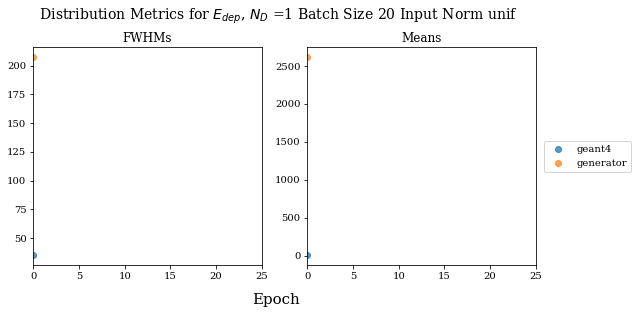

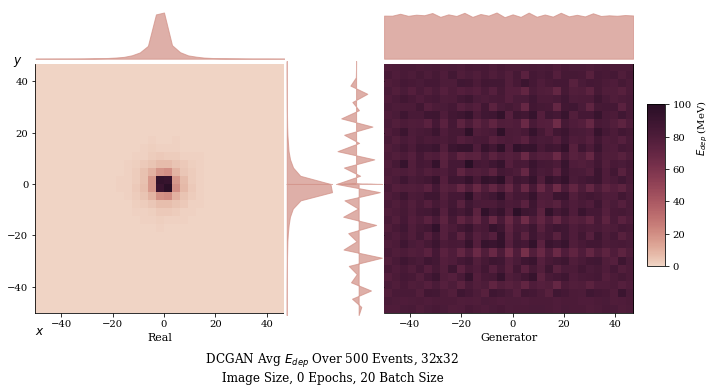

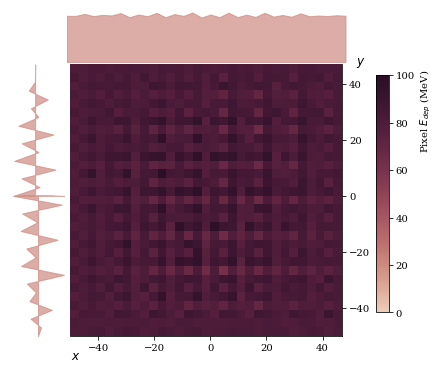

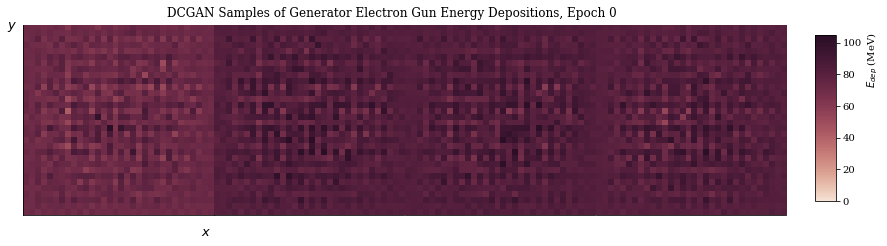

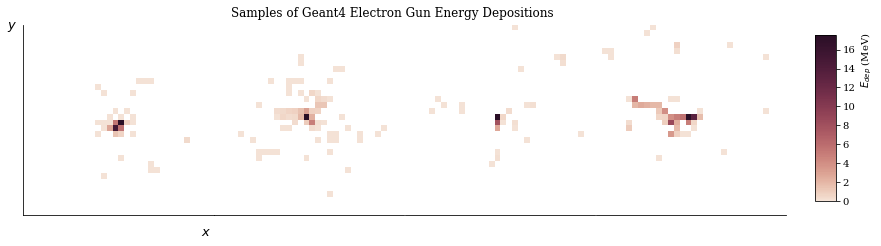

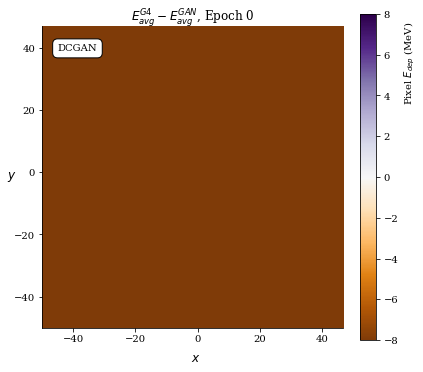

[0/50][0/1500] Loss_D: 1.7703 Loss_G: 6.9549 D(x): 0.4686 D(G(z)): 0.5701 / 0.0011
[0/50][100/1500] Loss_D: 0.0164 Loss_G: 7.2371 D(x): 0.9985 D(G(z)): 0.0013 / 0.0008
[0/50][200/1500] Loss_D: 0.0161 Loss_G: 7.1029 D(x): 0.9983 D(G(z)): 0.0012 / 0.0008
[0/50][300/1500] Loss_D: 0.0159 Loss_G: 7.2797 D(x): 0.9990 D(G(z)): 0.0011 / 0.0007
[0/50][400/1500] Loss_D: 0.0168 Loss_G: 7.3396 D(x): 0.9997 D(G(z)): 0.0013 / 0.0007
[0/50][500/1500] Loss_D: 0.0159 Loss_G: 7.0522 D(x): 0.9990 D(G(z)): 0.0009 / 0.0009
[0/50][600/1500] Loss_D: 27.6304 Loss_G: 0.0276 D(x): 1.0000 D(G(z)): 1.0000 / 1.0000
[0/50][700/1500] Loss_D: 27.6285 Loss_G: 0.0276 D(x): 1.0000 D(G(z)): 1.0000 / 1.0000
[0/50][800/1500] Loss_D: 27.6297 Loss_G: 0.0276 D(x): 1.0000 D(G(z)): 1.0000 / 1.0000
[0/50][900/1500] Loss_D: 27.6286 Loss_G: 0.0276 D(x): 0.9995 D(G(z)): 1.0000 / 1.0000
[0/50][1000/1500] Loss_D: 0.0502 Loss_G: 6.3906 D(x): 0.9900 D(G(z)): 0.0303 / 0.0017
[0/50][1100/1500] Loss_D: 0.2190 Loss_G: 3.4369 D(x): 0.8415 D

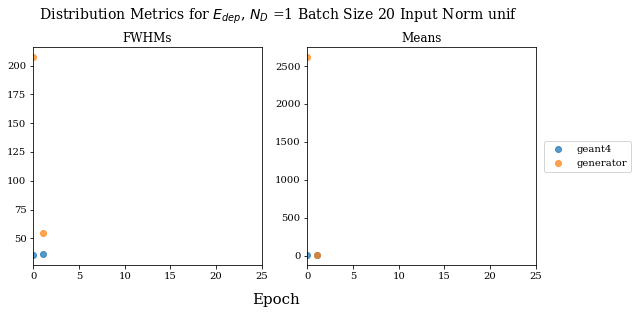

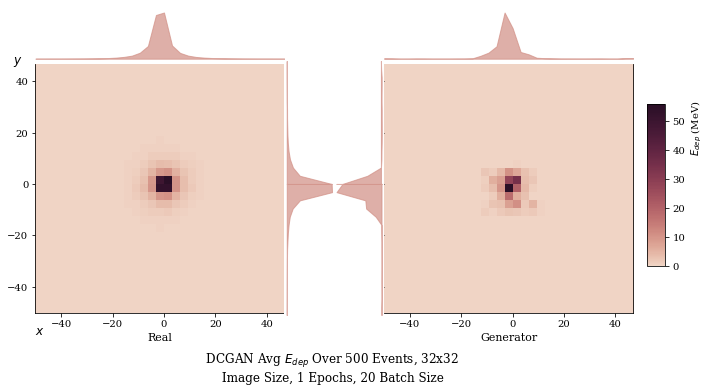

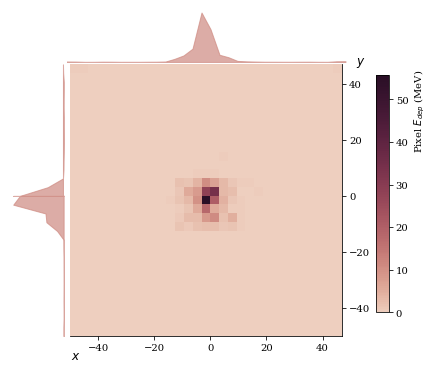

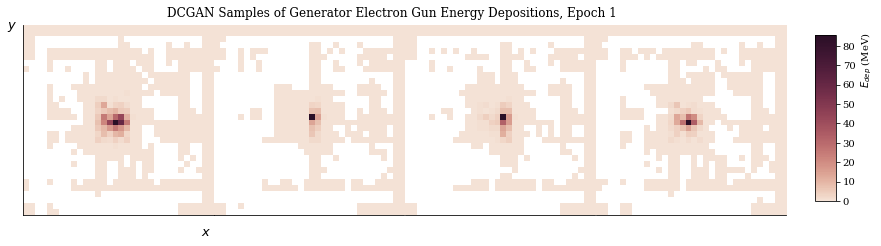

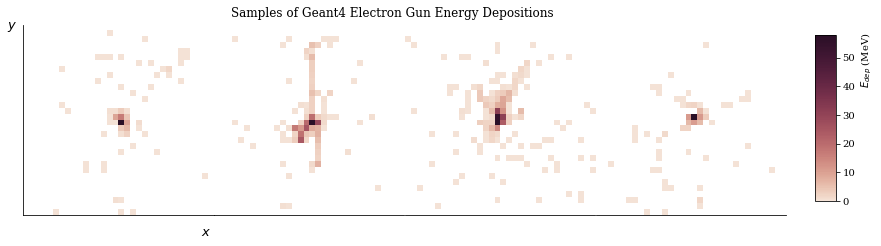

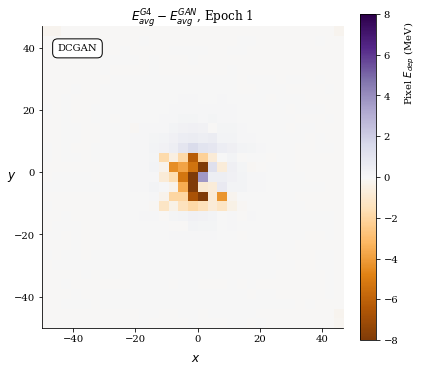

[1/50][0/1500] Loss_D: 0.6681 Loss_G: 2.6941 D(x): 0.8243 D(G(z)): 0.3072 / 0.0858
[1/50][100/1500] Loss_D: 0.3574 Loss_G: 4.9871 D(x): 0.8449 D(G(z)): 0.1548 / 0.0123
[1/50][200/1500] Loss_D: 0.9777 Loss_G: 2.9149 D(x): 0.5875 D(G(z)): 0.0390 / 0.1452
[1/50][300/1500] Loss_D: 1.3690 Loss_G: 1.9140 D(x): 0.4044 D(G(z)): 0.1910 / 0.2103
[1/50][400/1500] Loss_D: 0.6330 Loss_G: 5.2407 D(x): 0.9078 D(G(z)): 0.3274 / 0.0061
[1/50][500/1500] Loss_D: 0.2521 Loss_G: 3.0860 D(x): 0.8689 D(G(z)): 0.0784 / 0.0510
[1/50][600/1500] Loss_D: 0.0991 Loss_G: 3.9118 D(x): 0.9648 D(G(z)): 0.0507 / 0.0247
[1/50][700/1500] Loss_D: 0.4265 Loss_G: 2.3409 D(x): 0.7306 D(G(z)): 0.0596 / 0.1221
[1/50][800/1500] Loss_D: 0.5075 Loss_G: 3.3737 D(x): 0.6750 D(G(z)): 0.0199 / 0.1015
[1/50][900/1500] Loss_D: 0.4119 Loss_G: 3.0347 D(x): 0.7203 D(G(z)): 0.0438 / 0.0519
[1/50][1000/1500] Loss_D: 0.4765 Loss_G: 2.5353 D(x): 0.8502 D(G(z)): 0.2226 / 0.0933
[1/50][1100/1500] Loss_D: 0.7541 Loss_G: 9.1808 D(x): 0.9316 D(G(z

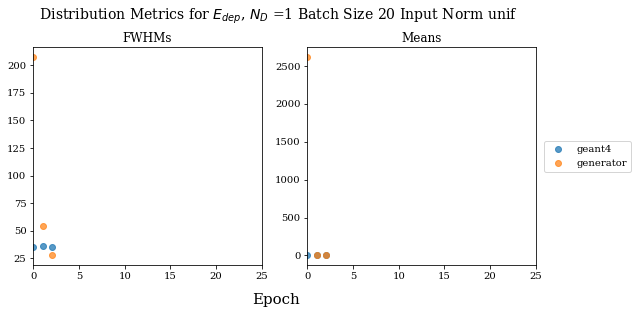

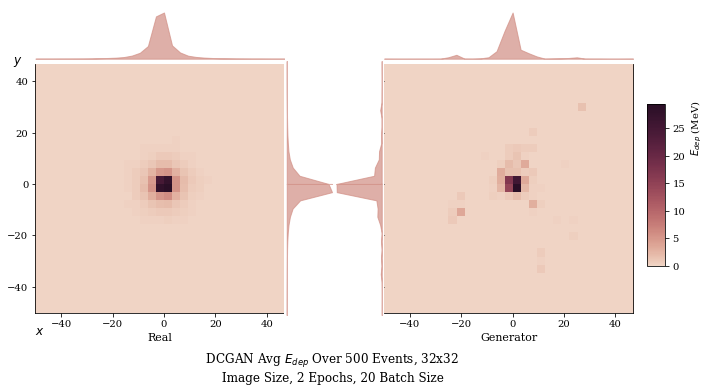

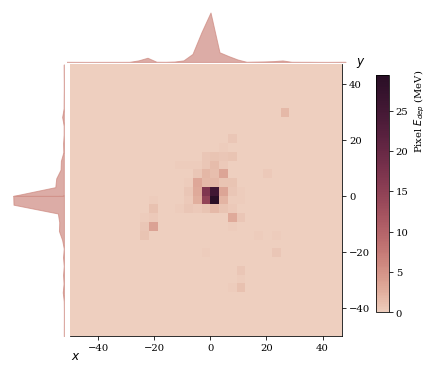

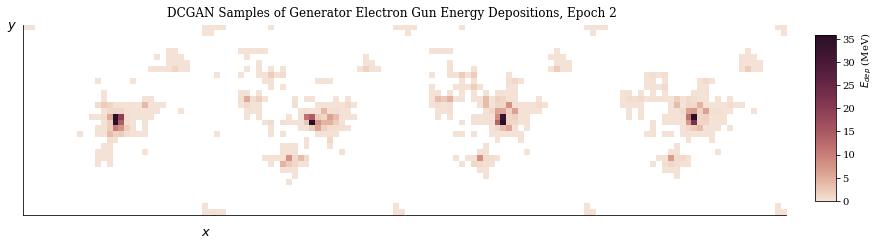

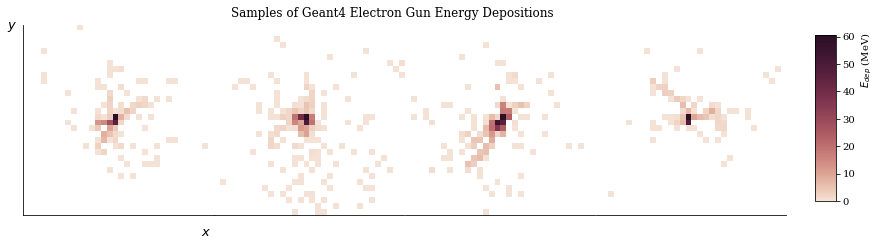

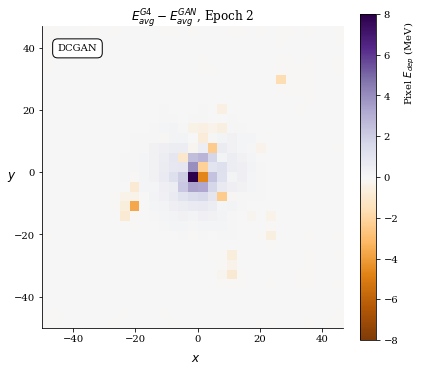

[2/50][0/1500] Loss_D: 0.2570 Loss_G: 3.9873 D(x): 0.8760 D(G(z)): 0.0970 / 0.0405
[2/50][100/1500] Loss_D: 0.6745 Loss_G: 4.2483 D(x): 0.9564 D(G(z)): 0.4244 / 0.0201
[2/50][200/1500] Loss_D: 0.7914 Loss_G: 3.2270 D(x): 0.8124 D(G(z)): 0.2562 / 0.0922
[2/50][300/1500] Loss_D: 0.2354 Loss_G: 4.5047 D(x): 0.9637 D(G(z)): 0.1696 / 0.0139
[2/50][400/1500] Loss_D: 0.3519 Loss_G: 4.9085 D(x): 0.9952 D(G(z)): 0.2561 / 0.0151
[2/50][500/1500] Loss_D: 0.8696 Loss_G: 4.5857 D(x): 0.8600 D(G(z)): 0.4420 / 0.0159
[2/50][600/1500] Loss_D: 0.0489 Loss_G: 5.0666 D(x): 0.9746 D(G(z)): 0.0130 / 0.0079
[2/50][700/1500] Loss_D: 0.2261 Loss_G: 4.2249 D(x): 0.8785 D(G(z)): 0.0641 / 0.0200
[2/50][800/1500] Loss_D: 0.3316 Loss_G: 4.2738 D(x): 0.9786 D(G(z)): 0.2296 / 0.0159
[2/50][900/1500] Loss_D: 0.1295 Loss_G: 3.5353 D(x): 0.9534 D(G(z)): 0.0689 / 0.0334
[2/50][1000/1500] Loss_D: 0.1661 Loss_G: 4.2300 D(x): 0.9276 D(G(z)): 0.0754 / 0.0203
[2/50][1100/1500] Loss_D: 0.9180 Loss_G: 0.8998 D(x): 0.5318 D(G(z

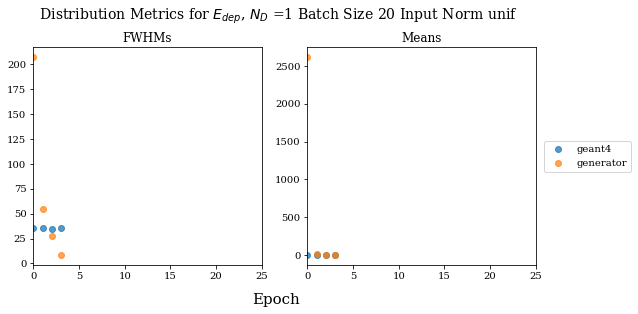

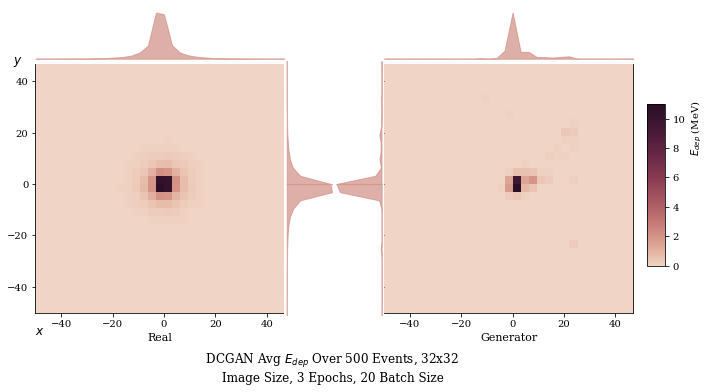

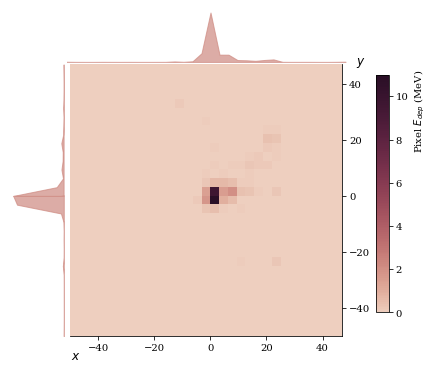

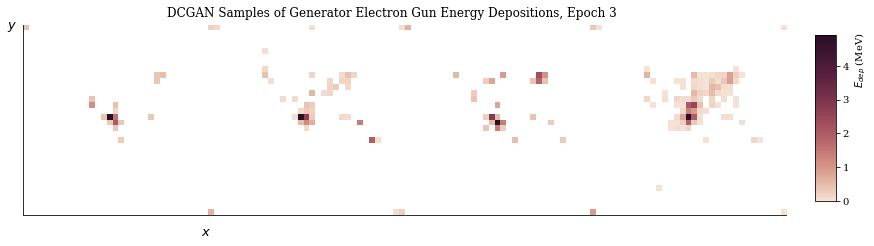

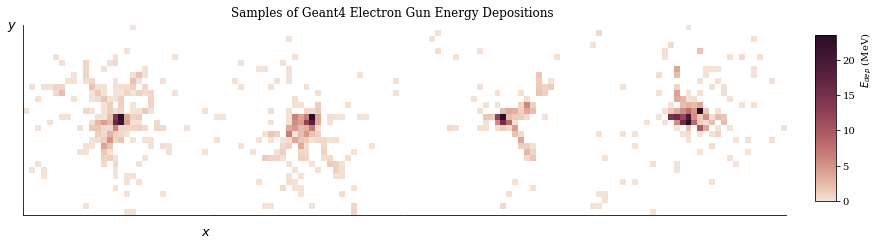

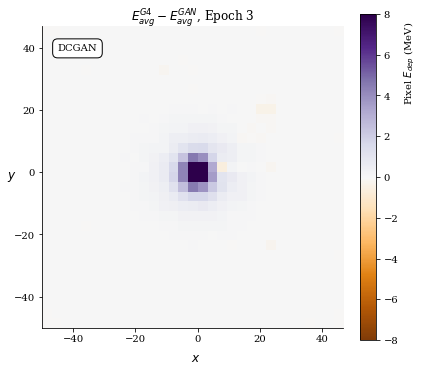

[3/50][0/1500] Loss_D: 0.1021 Loss_G: 5.2075 D(x): 0.9213 D(G(z)): 0.0047 / 0.0070
[3/50][100/1500] Loss_D: 0.1025 Loss_G: 4.3104 D(x): 0.9780 D(G(z)): 0.0680 / 0.0159
[3/50][200/1500] Loss_D: 0.2853 Loss_G: 2.9337 D(x): 0.8563 D(G(z)): 0.0435 / 0.0596
[3/50][300/1500] Loss_D: 0.2569 Loss_G: 3.4078 D(x): 0.9547 D(G(z)): 0.1649 / 0.0476
[3/50][400/1500] Loss_D: 0.2556 Loss_G: 4.1096 D(x): 0.8891 D(G(z)): 0.0507 / 0.0308
[3/50][500/1500] Loss_D: 0.4256 Loss_G: 3.1588 D(x): 0.7413 D(G(z)): 0.0312 / 0.0785
[3/50][600/1500] Loss_D: 0.0568 Loss_G: 5.8394 D(x): 0.9662 D(G(z)): 0.0055 / 0.0042
[3/50][700/1500] Loss_D: 0.0881 Loss_G: 5.1967 D(x): 0.9633 D(G(z)): 0.0381 / 0.0233
[3/50][800/1500] Loss_D: 0.2547 Loss_G: 3.3335 D(x): 0.8379 D(G(z)): 0.0357 / 0.0554
[3/50][900/1500] Loss_D: 0.1498 Loss_G: 4.8406 D(x): 0.9959 D(G(z)): 0.1261 / 0.0093
[3/50][1000/1500] Loss_D: 0.4568 Loss_G: 4.3154 D(x): 0.8698 D(G(z)): 0.0795 / 0.0220
[3/50][1100/1500] Loss_D: 0.4399 Loss_G: 3.1970 D(x): 0.8218 D(G(z

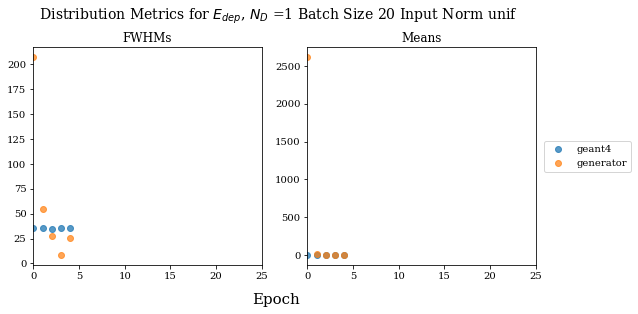

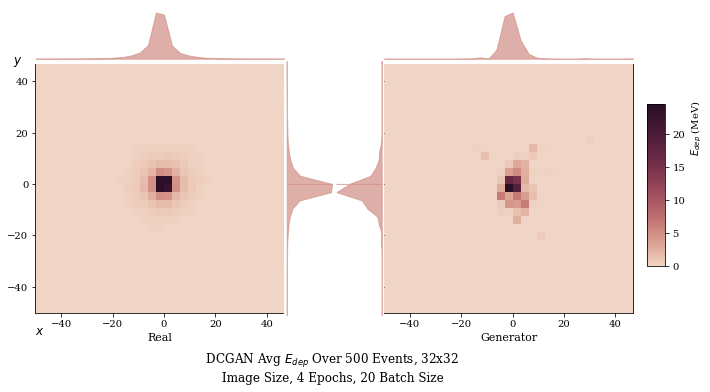

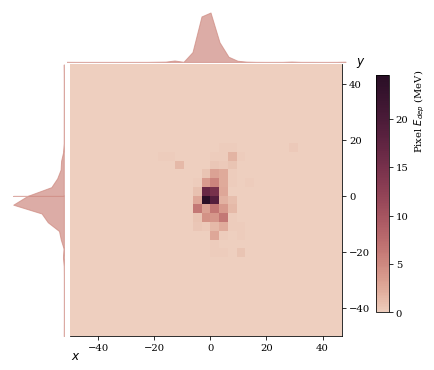

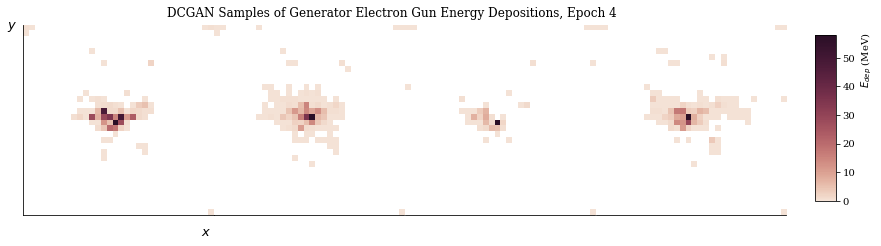

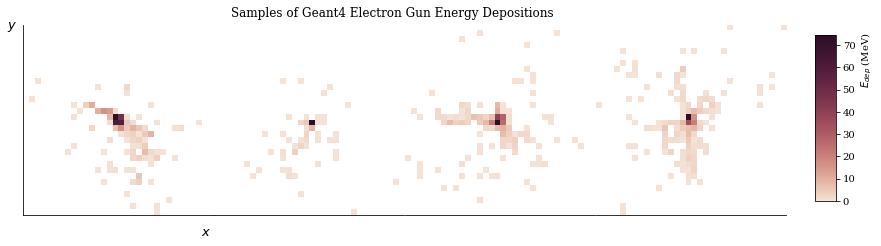

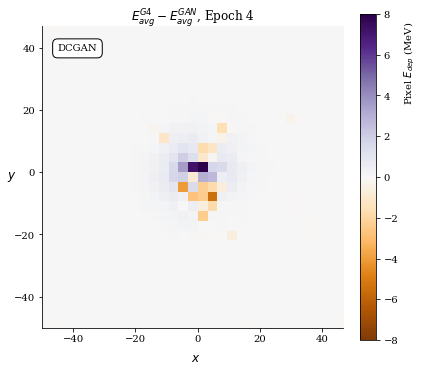

[4/50][0/1500] Loss_D: 0.0711 Loss_G: 4.5129 D(x): 0.9841 D(G(z)): 0.0402 / 0.0149
[4/50][100/1500] Loss_D: 0.0881 Loss_G: 5.2306 D(x): 0.9649 D(G(z)): 0.0359 / 0.0136
[4/50][200/1500] Loss_D: 1.3117 Loss_G: 9.2789 D(x): 0.5032 D(G(z)): 0.0000 / 0.0011
[4/50][300/1500] Loss_D: 0.0831 Loss_G: 4.4887 D(x): 0.9589 D(G(z)): 0.0261 / 0.0152
[4/50][400/1500] Loss_D: 1.2824 Loss_G: 9.5406 D(x): 0.9927 D(G(z)): 0.6642 / 0.0003
[4/50][500/1500] Loss_D: 0.2056 Loss_G: 4.1714 D(x): 0.9476 D(G(z)): 0.1229 / 0.0188
[4/50][600/1500] Loss_D: 0.0819 Loss_G: 5.0531 D(x): 0.9925 D(G(z)): 0.0603 / 0.0096
[4/50][700/1500] Loss_D: 0.2153 Loss_G: 4.1013 D(x): 0.9525 D(G(z)): 0.1085 / 0.0213
[4/50][800/1500] Loss_D: 0.0979 Loss_G: 4.4325 D(x): 0.9481 D(G(z)): 0.0326 / 0.0157
[4/50][900/1500] Loss_D: 0.1324 Loss_G: 8.3747 D(x): 0.9899 D(G(z)): 0.0979 / 0.0036
[4/50][1000/1500] Loss_D: 0.0757 Loss_G: 6.8264 D(x): 0.9476 D(G(z)): 0.0008 / 0.0018
[4/50][1100/1500] Loss_D: 0.1287 Loss_G: 4.1256 D(x): 0.9436 D(G(z

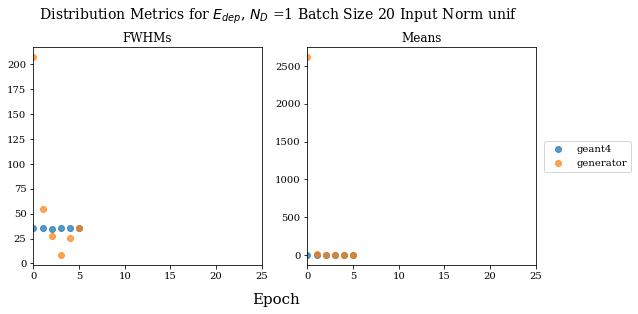

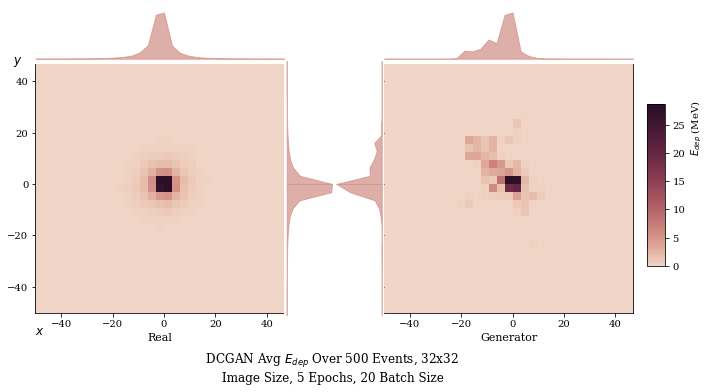

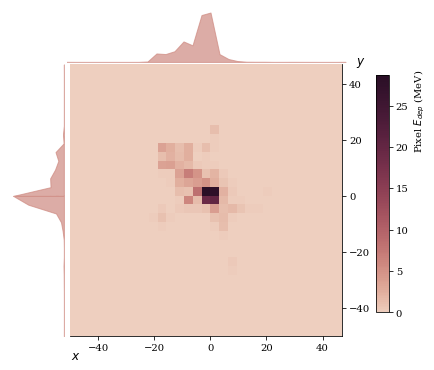

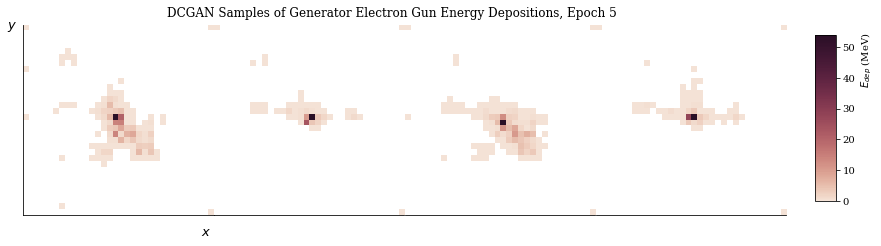

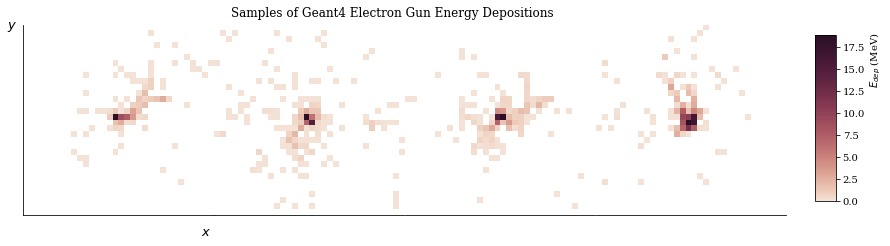

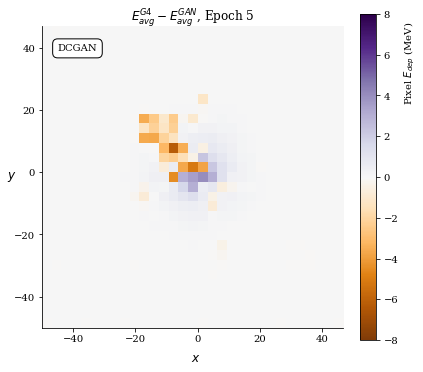

[5/50][0/1500] Loss_D: 0.4645 Loss_G: 4.9509 D(x): 0.8309 D(G(z)): 0.1715 / 0.0232
[5/50][100/1500] Loss_D: 0.2944 Loss_G: 3.4344 D(x): 0.8459 D(G(z)): 0.0341 / 0.0558
[5/50][200/1500] Loss_D: 0.6472 Loss_G: 1.0138 D(x): 0.6913 D(G(z)): 0.0315 / 0.4675
[5/50][300/1500] Loss_D: 0.1462 Loss_G: 6.4578 D(x): 0.8889 D(G(z)): 0.0063 / 0.0021
[5/50][400/1500] Loss_D: 0.0864 Loss_G: 4.2084 D(x): 0.9984 D(G(z)): 0.0685 / 0.0200
[5/50][500/1500] Loss_D: 0.0707 Loss_G: 6.6919 D(x): 0.9535 D(G(z)): 0.0042 / 0.0036
[5/50][600/1500] Loss_D: 0.0338 Loss_G: 7.3439 D(x): 0.9853 D(G(z)): 0.0046 / 0.0008
[5/50][700/1500] Loss_D: 0.6580 Loss_G: 3.6681 D(x): 0.7915 D(G(z)): 0.1515 / 0.0392
[5/50][800/1500] Loss_D: 0.1012 Loss_G: 4.5860 D(x): 0.9253 D(G(z)): 0.0043 / 0.0198
[5/50][900/1500] Loss_D: 0.1247 Loss_G: 5.3865 D(x): 0.9921 D(G(z)): 0.0944 / 0.0097
[5/50][1000/1500] Loss_D: 0.5690 Loss_G: 7.2295 D(x): 0.7155 D(G(z)): 0.0040 / 0.0016
[5/50][1100/1500] Loss_D: 0.4609 Loss_G: 2.0778 D(x): 0.7372 D(G(z

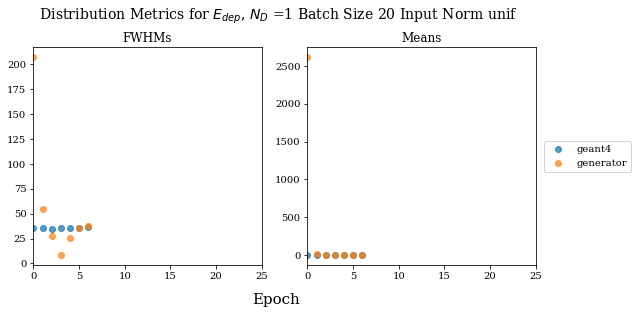

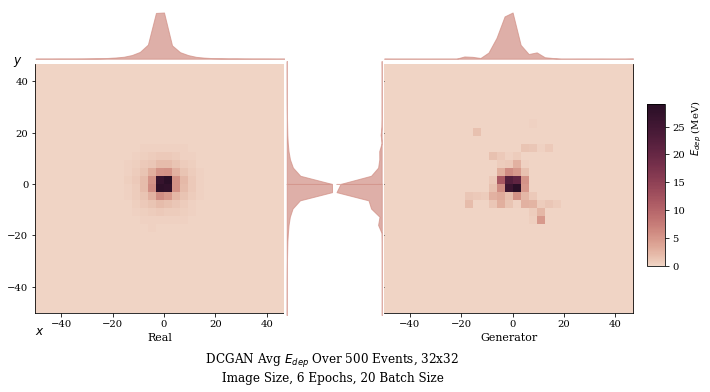

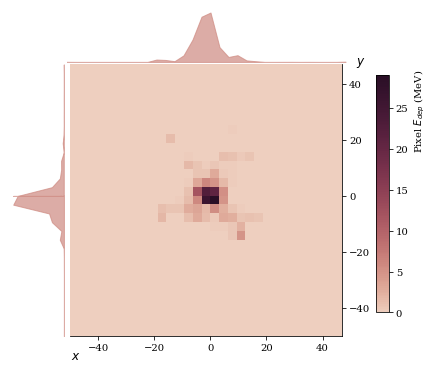

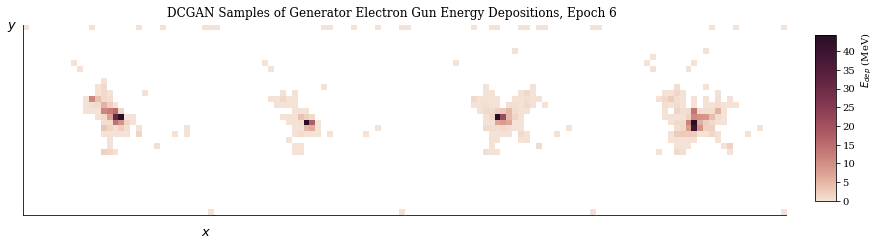

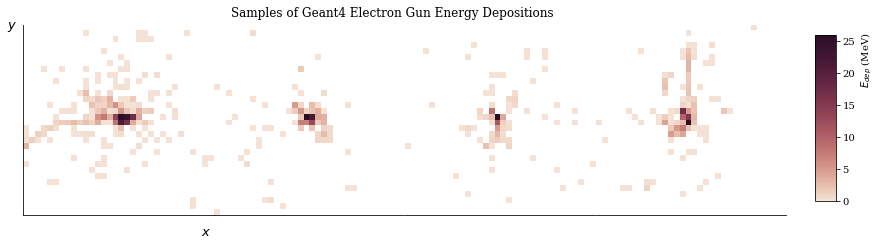

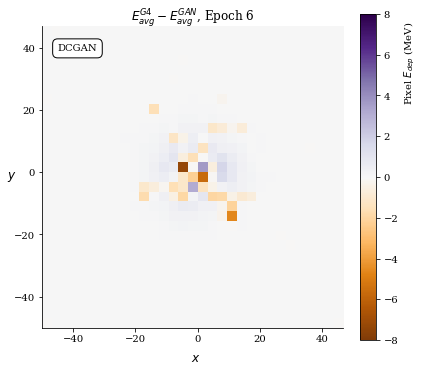

[6/50][0/1500] Loss_D: 0.1293 Loss_G: 4.9368 D(x): 0.9816 D(G(z)): 0.0905 / 0.0094
[6/50][100/1500] Loss_D: 0.3810 Loss_G: 4.6063 D(x): 0.9055 D(G(z)): 0.2290 / 0.0120
[6/50][200/1500] Loss_D: 0.3105 Loss_G: 3.2718 D(x): 0.9032 D(G(z)): 0.0574 / 0.0530
[6/50][300/1500] Loss_D: 0.1551 Loss_G: 3.8788 D(x): 0.9203 D(G(z)): 0.0536 / 0.0264
[6/50][400/1500] Loss_D: 0.0401 Loss_G: 4.7653 D(x): 0.9971 D(G(z)): 0.0217 / 0.0141
[6/50][500/1500] Loss_D: 0.1992 Loss_G: 6.7471 D(x): 0.9667 D(G(z)): 0.0868 / 0.0076
[6/50][600/1500] Loss_D: 0.0240 Loss_G: 7.7918 D(x): 0.9978 D(G(z)): 0.0054 / 0.0007
[6/50][700/1500] Loss_D: 0.2050 Loss_G: 4.6008 D(x): 0.9124 D(G(z)): 0.0891 / 0.0177
[6/50][800/1500] Loss_D: 0.0603 Loss_G: 4.8537 D(x): 0.9722 D(G(z)): 0.0200 / 0.0096
[6/50][900/1500] Loss_D: 0.0330 Loss_G: 5.7298 D(x): 0.9927 D(G(z)): 0.0126 / 0.0054
[6/50][1000/1500] Loss_D: 0.0907 Loss_G: 5.8712 D(x): 0.9882 D(G(z)): 0.0627 / 0.0104
[6/50][1100/1500] Loss_D: 0.1184 Loss_G: 3.5557 D(x): 0.9250 D(G(z

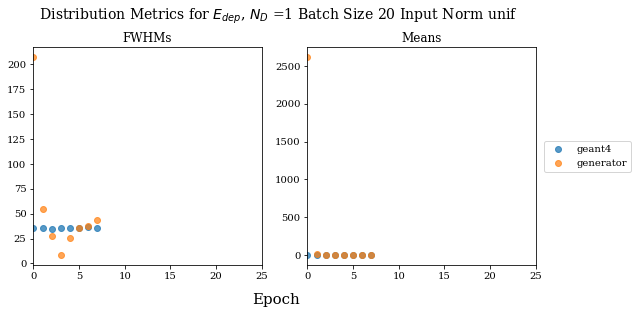

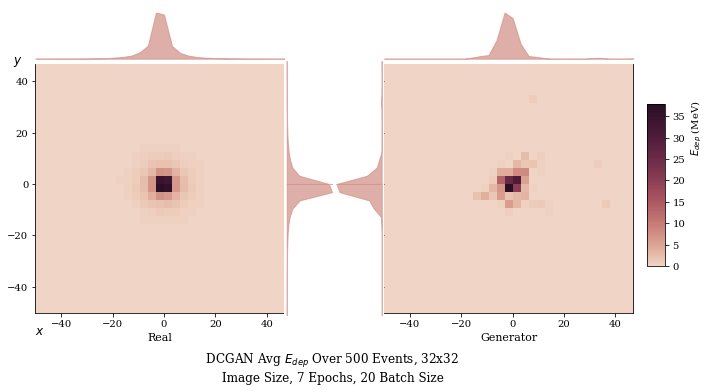

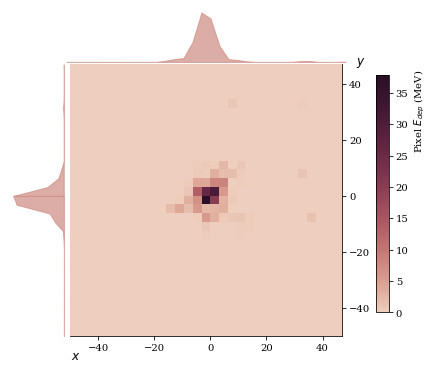

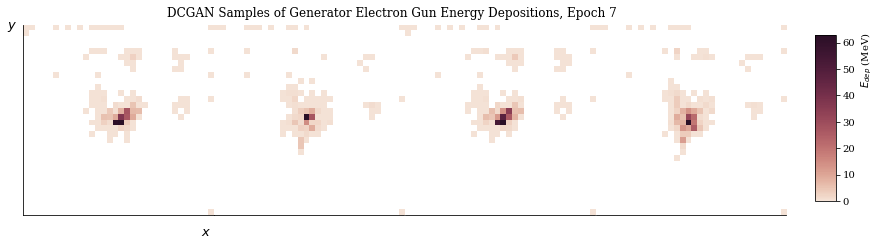

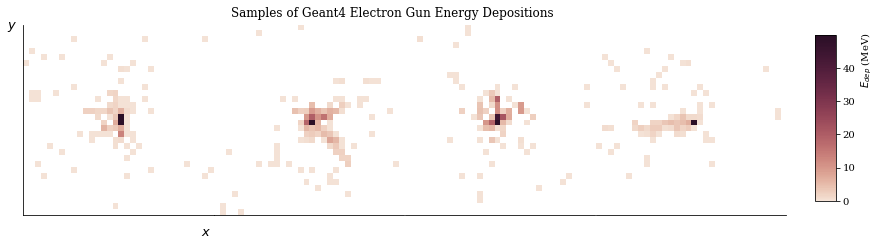

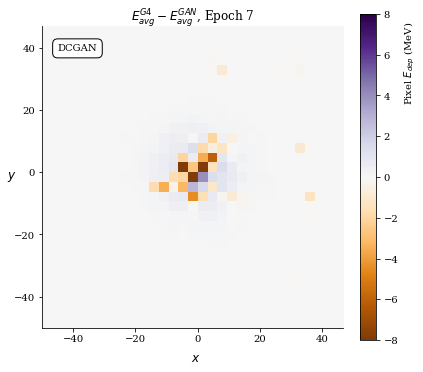

[7/50][0/1500] Loss_D: 0.1302 Loss_G: 4.0176 D(x): 0.9235 D(G(z)): 0.0300 / 0.0221
[7/50][100/1500] Loss_D: 0.0856 Loss_G: 9.1036 D(x): 0.9348 D(G(z)): 0.0003 / 0.0006
[7/50][200/1500] Loss_D: 0.0468 Loss_G: 4.9320 D(x): 0.9800 D(G(z)): 0.0120 / 0.0095
[7/50][300/1500] Loss_D: 0.0555 Loss_G: 5.1551 D(x): 0.9663 D(G(z)): 0.0110 / 0.0073
[7/50][400/1500] Loss_D: 0.9885 Loss_G: 14.5579 D(x): 0.9995 D(G(z)): 0.5718 / 0.0000
[7/50][500/1500] Loss_D: 0.1773 Loss_G: 5.0878 D(x): 0.8962 D(G(z)): 0.0221 / 0.0085
[7/50][600/1500] Loss_D: 0.1395 Loss_G: 5.3089 D(x): 0.9532 D(G(z)): 0.0648 / 0.0095
[7/50][700/1500] Loss_D: 0.1427 Loss_G: 2.8142 D(x): 0.9172 D(G(z)): 0.0398 / 0.0964
[7/50][800/1500] Loss_D: 0.1268 Loss_G: 4.7051 D(x): 0.9236 D(G(z)): 0.0270 / 0.0222
[7/50][900/1500] Loss_D: 0.0385 Loss_G: 6.1532 D(x): 0.9792 D(G(z)): 0.0039 / 0.0037
[7/50][1000/1500] Loss_D: 0.0449 Loss_G: 4.8907 D(x): 0.9965 D(G(z)): 0.0255 / 0.0159
[7/50][1100/1500] Loss_D: 0.3288 Loss_G: 2.3085 D(x): 0.7726 D(G(

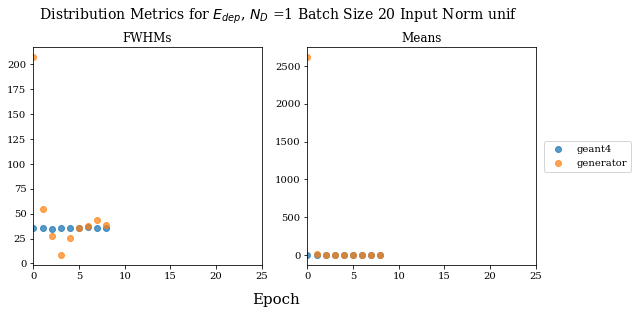

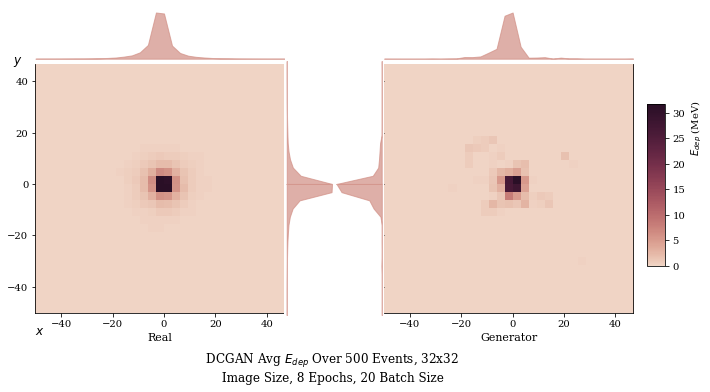

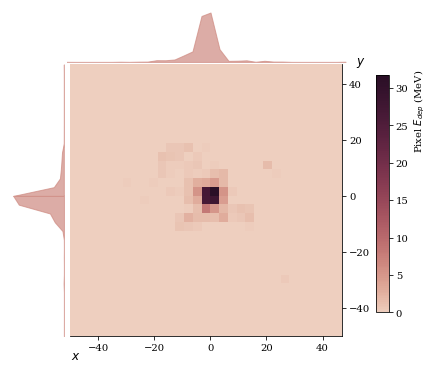

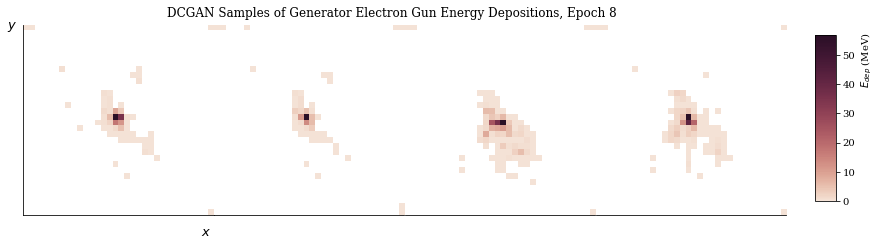

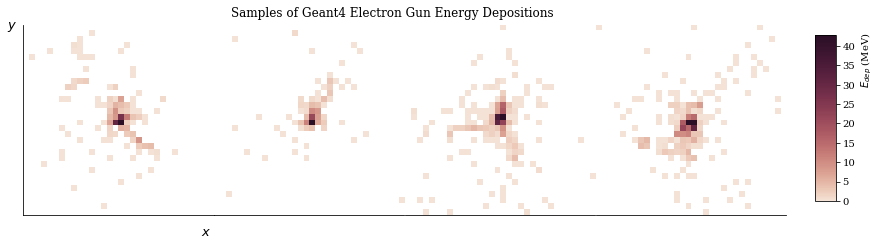

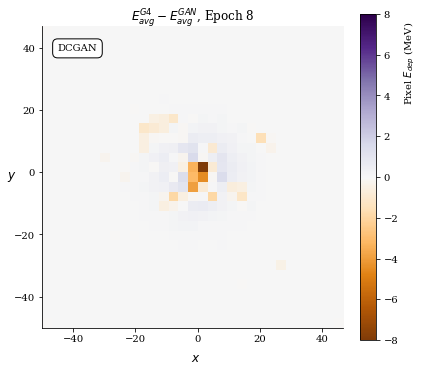

[8/50][0/1500] Loss_D: 0.0733 Loss_G: 5.1432 D(x): 0.9524 D(G(z)): 0.0143 / 0.0094
[8/50][100/1500] Loss_D: 0.0627 Loss_G: 5.1026 D(x): 0.9758 D(G(z)): 0.0177 / 0.0185
[8/50][200/1500] Loss_D: 0.0361 Loss_G: 5.4526 D(x): 0.9869 D(G(z)): 0.0110 / 0.0066
[8/50][300/1500] Loss_D: 0.1330 Loss_G: 3.9425 D(x): 0.9290 D(G(z)): 0.0355 / 0.0274
[8/50][400/1500] Loss_D: 0.0631 Loss_G: 4.9112 D(x): 0.9955 D(G(z)): 0.0427 / 0.0104
[8/50][500/1500] Loss_D: 0.0460 Loss_G: 5.1901 D(x): 0.9850 D(G(z)): 0.0195 / 0.0060
[8/50][600/1500] Loss_D: 0.0307 Loss_G: 5.2332 D(x): 0.9956 D(G(z)): 0.0137 / 0.0078
[8/50][700/1500] Loss_D: 0.0319 Loss_G: 4.8852 D(x): 0.9981 D(G(z)): 0.0172 / 0.0089
[8/50][800/1500] Loss_D: 0.5831 Loss_G: 7.1220 D(x): 0.7323 D(G(z)): 0.0009 / 0.0021
[8/50][900/1500] Loss_D: 0.0265 Loss_G: 9.4960 D(x): 0.9933 D(G(z)): 0.0053 / 0.0008
[8/50][1000/1500] Loss_D: 0.0336 Loss_G: 4.4981 D(x): 0.9997 D(G(z)): 0.0185 / 0.0160
[8/50][1100/1500] Loss_D: 0.0587 Loss_G: 5.0771 D(x): 0.9834 D(G(z

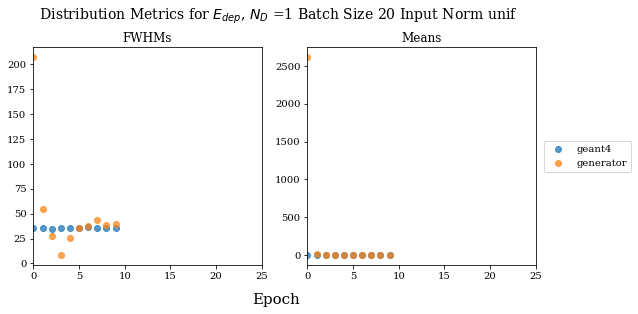

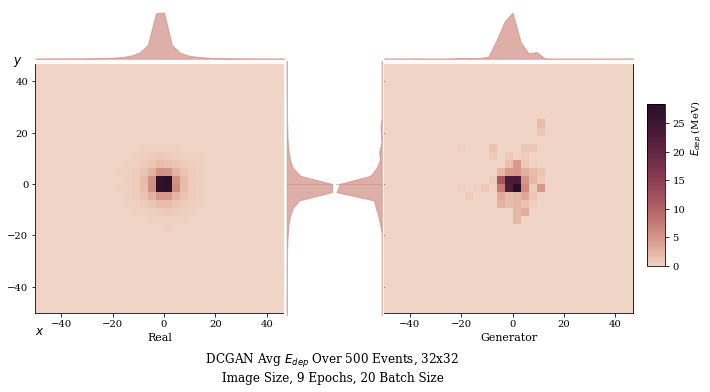

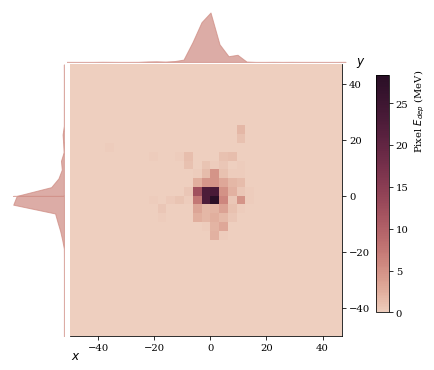

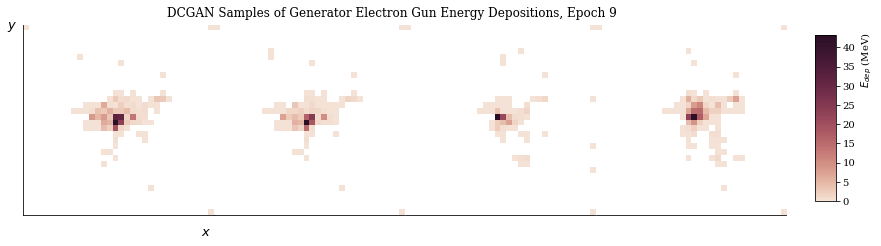

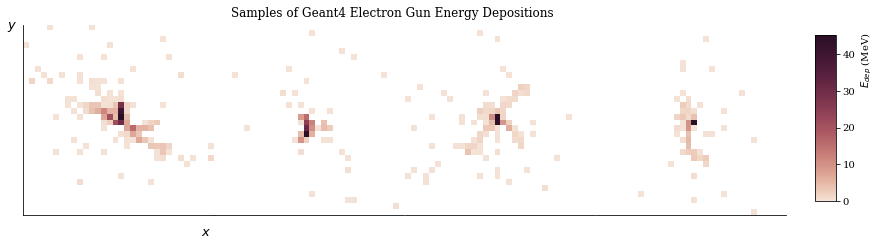

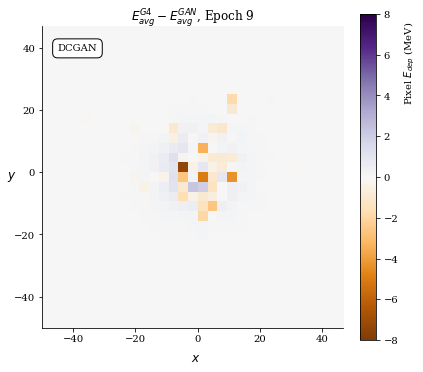

[9/50][0/1500] Loss_D: 0.1323 Loss_G: 4.5839 D(x): 0.9128 D(G(z)): 0.0199 / 0.0112
[9/50][100/1500] Loss_D: 0.0548 Loss_G: 4.3241 D(x): 0.9782 D(G(z)): 0.0229 / 0.0153
[9/50][200/1500] Loss_D: 0.0799 Loss_G: 4.6866 D(x): 0.9596 D(G(z)): 0.0267 / 0.0140
[9/50][300/1500] Loss_D: 0.1493 Loss_G: 5.4837 D(x): 0.8843 D(G(z)): 0.0044 / 0.0062
[9/50][400/1500] Loss_D: 0.0482 Loss_G: 4.3329 D(x): 0.9947 D(G(z)): 0.0308 / 0.0159
[9/50][500/1500] Loss_D: 0.1713 Loss_G: 3.2373 D(x): 0.9032 D(G(z)): 0.0535 / 0.0465
[9/50][600/1500] Loss_D: 0.0805 Loss_G: 4.0227 D(x): 0.9682 D(G(z)): 0.0240 / 0.0237
[9/50][700/1500] Loss_D: 0.1803 Loss_G: 2.9056 D(x): 0.8990 D(G(z)): 0.0358 / 0.0693
[9/50][800/1500] Loss_D: 0.0540 Loss_G: 5.3381 D(x): 0.9764 D(G(z)): 0.0144 / 0.0109
[9/50][900/1500] Loss_D: 0.2726 Loss_G: 16.7447 D(x): 1.0000 D(G(z)): 0.2058 / 0.0000
[9/50][1000/1500] Loss_D: 0.0264 Loss_G: 5.0531 D(x): 0.9984 D(G(z)): 0.0089 / 0.0075
[9/50][1100/1500] Loss_D: 0.2474 Loss_G: 3.1969 D(x): 0.8847 D(G(

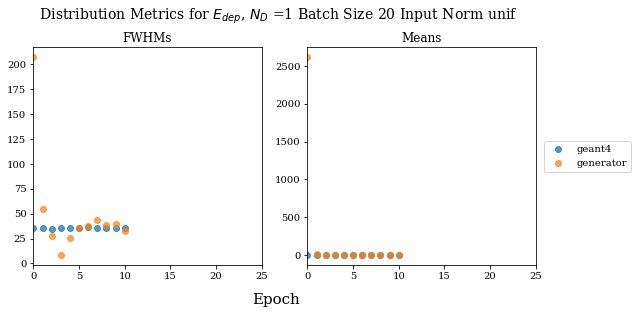

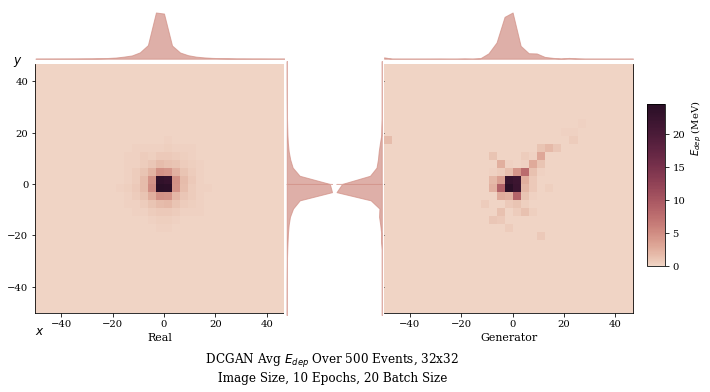

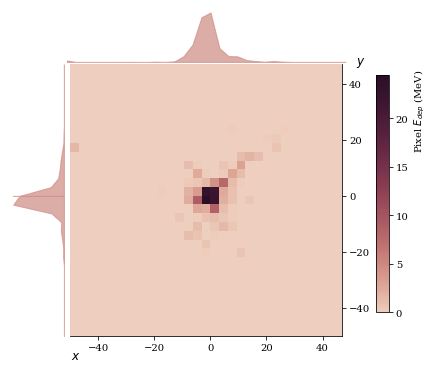

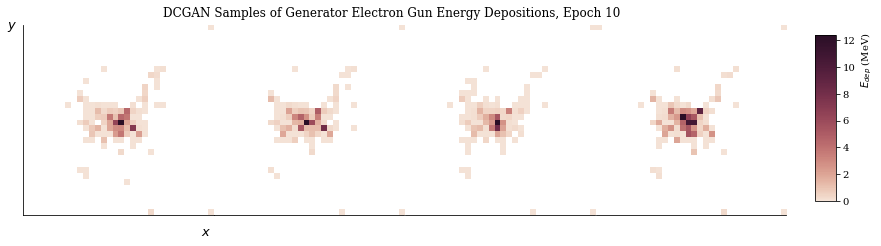

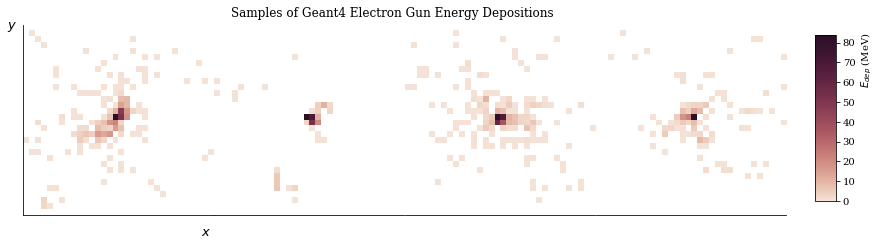

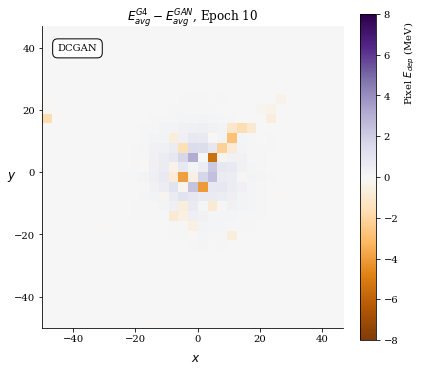

[10/50][0/1500] Loss_D: 0.0651 Loss_G: 5.5234 D(x): 0.9603 D(G(z)): 0.0054 / 0.0056
[10/50][100/1500] Loss_D: 0.5571 Loss_G: 10.2743 D(x): 0.9993 D(G(z)): 0.3792 / 0.0000
[10/50][200/1500] Loss_D: 0.0871 Loss_G: 4.7189 D(x): 0.9413 D(G(z)): 0.0096 / 0.0141
[10/50][300/1500] Loss_D: 0.0911 Loss_G: 4.9402 D(x): 0.9458 D(G(z)): 0.0148 / 0.0112
[10/50][400/1500] Loss_D: 0.0386 Loss_G: 6.0182 D(x): 0.9947 D(G(z)): 0.0190 / 0.0076
[10/50][500/1500] Loss_D: 0.0977 Loss_G: 5.1539 D(x): 0.9635 D(G(z)): 0.0462 / 0.0110
[10/50][600/1500] Loss_D: 0.0339 Loss_G: 6.1617 D(x): 0.9971 D(G(z)): 0.0172 / 0.0033
[10/50][700/1500] Loss_D: 0.0708 Loss_G: 4.3446 D(x): 0.9708 D(G(z)): 0.0298 / 0.0182
[10/50][800/1500] Loss_D: 0.3315 Loss_G: 4.5039 D(x): 0.8209 D(G(z)): 0.0009 / 0.0267
[10/50][900/1500] Loss_D: 0.4582 Loss_G: 5.7308 D(x): 0.9092 D(G(z)): 0.0740 / 0.0102
[10/50][1000/1500] Loss_D: 0.0652 Loss_G: 4.8815 D(x): 0.9901 D(G(z)): 0.0402 / 0.0149
[10/50][1100/1500] Loss_D: 0.1122 Loss_G: 3.8458 D(x):

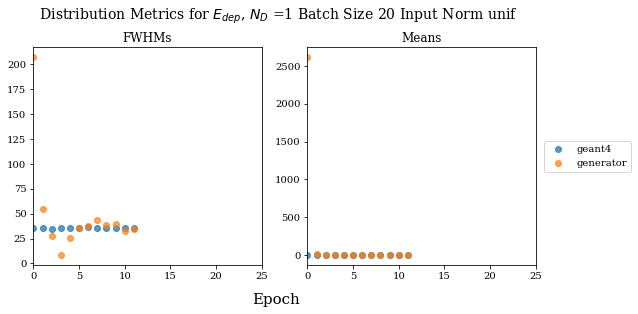

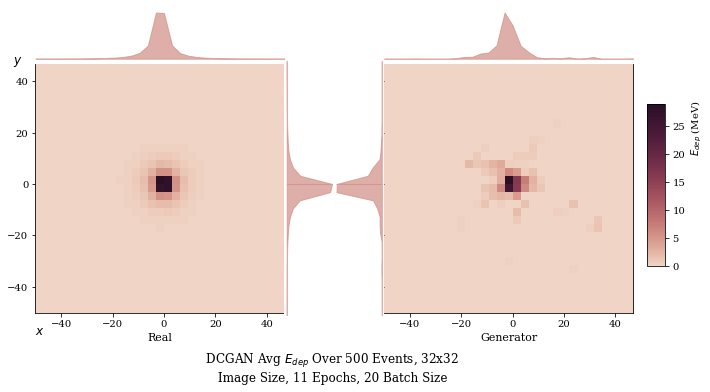

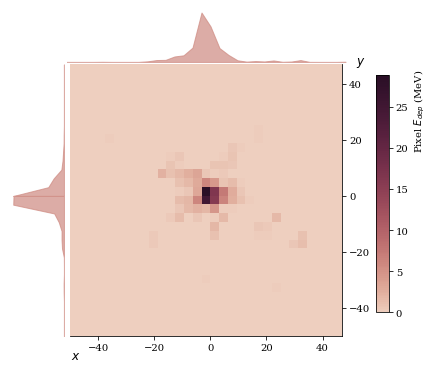

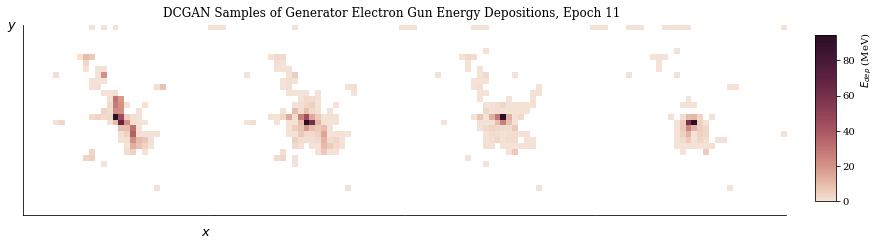

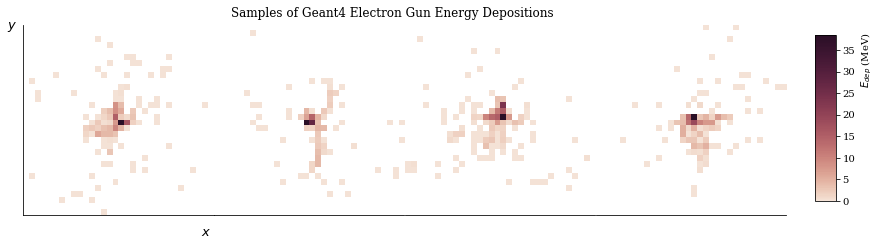

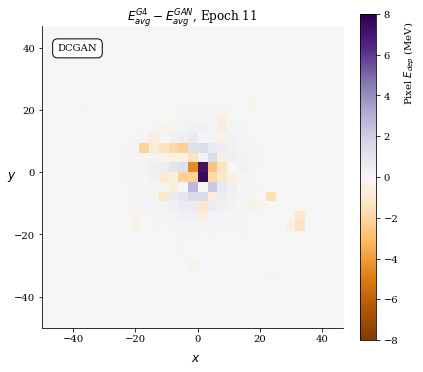

[11/50][0/1500] Loss_D: 0.0759 Loss_G: 4.6505 D(x): 0.9617 D(G(z)): 0.0257 / 0.0138
[11/50][100/1500] Loss_D: 0.0444 Loss_G: 5.2798 D(x): 0.9928 D(G(z)): 0.0252 / 0.0128
[11/50][200/1500] Loss_D: 0.1439 Loss_G: 3.8660 D(x): 0.9420 D(G(z)): 0.0625 / 0.0316
[11/50][300/1500] Loss_D: 0.4138 Loss_G: 4.3897 D(x): 0.7840 D(G(z)): 0.0168 / 0.1042
[11/50][400/1500] Loss_D: 0.1926 Loss_G: 7.4047 D(x): 0.9983 D(G(z)): 0.1573 / 0.0010
[11/50][500/1500] Loss_D: 0.0227 Loss_G: 5.7711 D(x): 0.9957 D(G(z)): 0.0054 / 0.0049
[11/50][600/1500] Loss_D: 0.0220 Loss_G: 6.6265 D(x): 0.9994 D(G(z)): 0.0054 / 0.0017
[11/50][700/1500] Loss_D: 0.0734 Loss_G: 7.4026 D(x): 0.9533 D(G(z)): 0.0009 / 0.0034
[11/50][800/1500] Loss_D: 0.0345 Loss_G: 5.1978 D(x): 0.9872 D(G(z)): 0.0074 / 0.0059
[11/50][900/1500] Loss_D: 0.0416 Loss_G: 5.4318 D(x): 0.9936 D(G(z)): 0.0206 / 0.0104
[11/50][1000/1500] Loss_D: 0.0358 Loss_G: 4.9645 D(x): 0.9962 D(G(z)): 0.0169 / 0.0110
[11/50][1100/1500] Loss_D: 0.2106 Loss_G: 3.3914 D(x): 

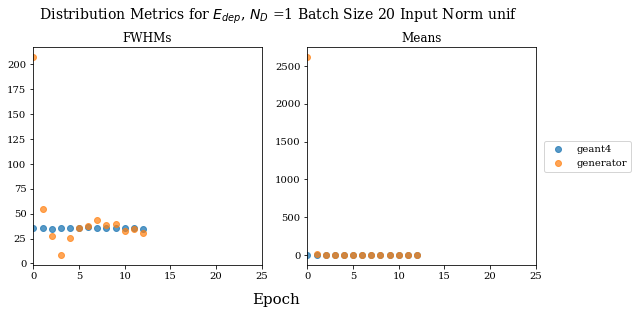

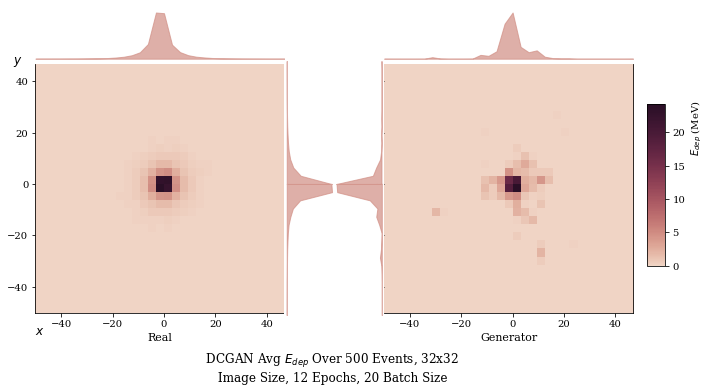

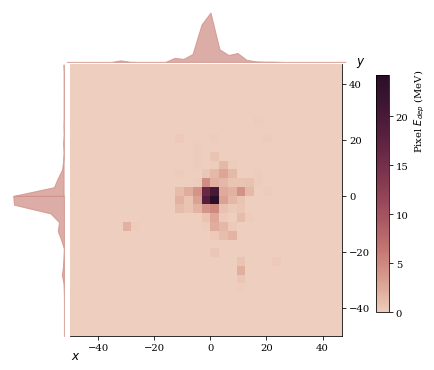

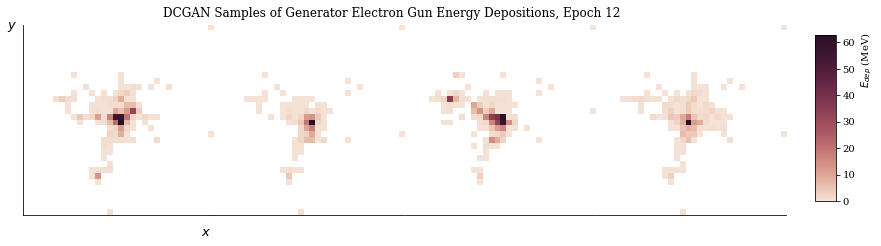

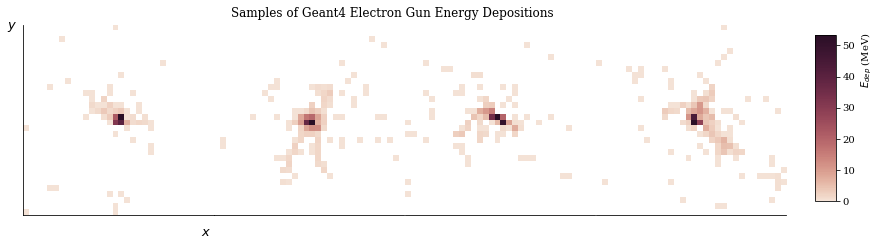

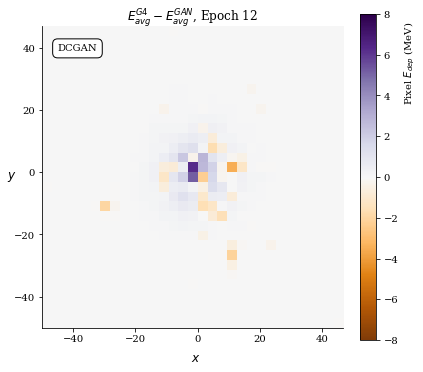

[12/50][0/1500] Loss_D: 0.0509 Loss_G: 5.5748 D(x): 0.9669 D(G(z)): 0.0060 / 0.0044
[12/50][100/1500] Loss_D: 0.1428 Loss_G: 3.8925 D(x): 0.9108 D(G(z)): 0.0333 / 0.0307
[12/50][200/1500] Loss_D: 0.1515 Loss_G: 3.5746 D(x): 0.9112 D(G(z)): 0.0358 / 0.0391
[12/50][300/1500] Loss_D: 0.0824 Loss_G: 4.7645 D(x): 0.9850 D(G(z)): 0.0535 / 0.0188
[12/50][400/1500] Loss_D: 0.1358 Loss_G: 4.4305 D(x): 0.9759 D(G(z)): 0.0907 / 0.0347
[12/50][500/1500] Loss_D: 0.0682 Loss_G: 4.0044 D(x): 0.9670 D(G(z)): 0.0221 / 0.0211
[12/50][600/1500] Loss_D: 0.0247 Loss_G: 5.5020 D(x): 0.9997 D(G(z)): 0.0074 / 0.0067
[12/50][700/1500] Loss_D: 0.1133 Loss_G: 3.4732 D(x): 0.9426 D(G(z)): 0.0348 / 0.0389
[12/50][800/1500] Loss_D: 0.0445 Loss_G: 4.8475 D(x): 0.9987 D(G(z)): 0.0275 / 0.0096
[12/50][900/1500] Loss_D: 0.1265 Loss_G: 4.5086 D(x): 1.0000 D(G(z)): 0.0999 / 0.0177
[12/50][1000/1500] Loss_D: 0.1307 Loss_G: 5.3457 D(x): 0.9702 D(G(z)): 0.0754 / 0.0066
[12/50][1100/1500] Loss_D: 0.2347 Loss_G: 3.4370 D(x): 

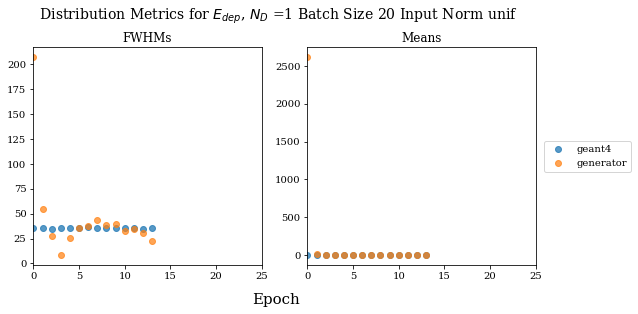

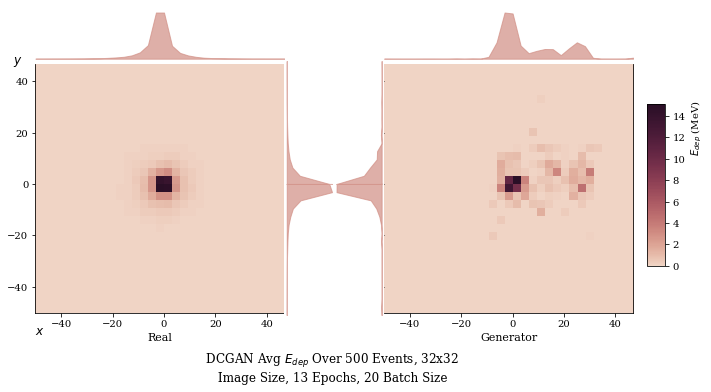

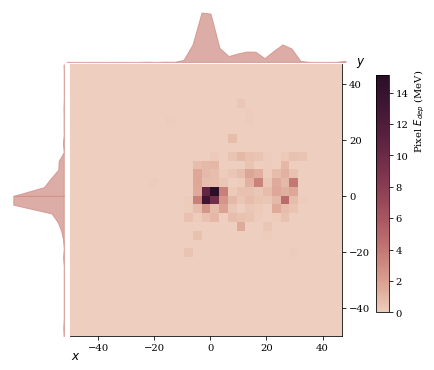

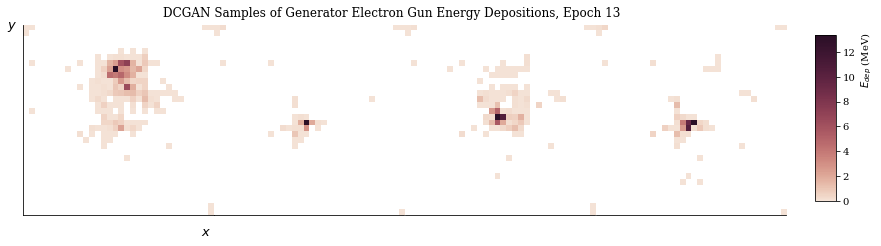

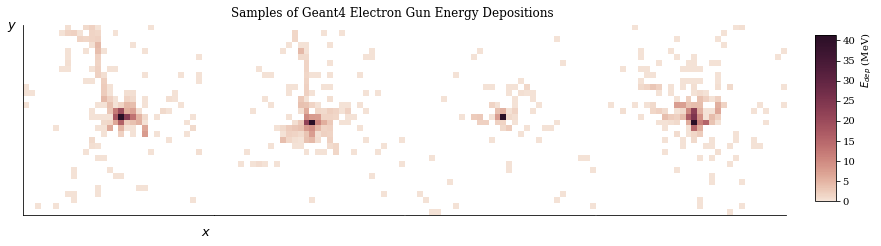

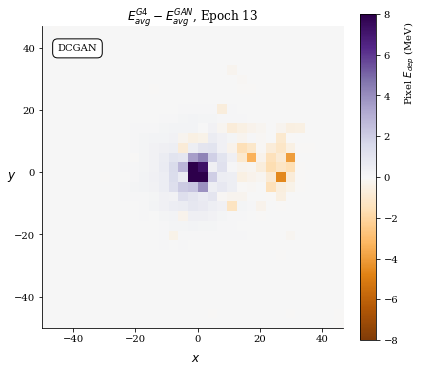

[13/50][0/1500] Loss_D: 0.0591 Loss_G: 4.7549 D(x): 0.9988 D(G(z)): 0.0407 / 0.0116
[13/50][100/1500] Loss_D: 0.1401 Loss_G: 5.1250 D(x): 0.9064 D(G(z)): 0.0111 / 0.0256
[13/50][200/1500] Loss_D: 1.2599 Loss_G: 2.2080 D(x): 0.5732 D(G(z)): 0.0674 / 0.2487
[13/50][300/1500] Loss_D: 0.1397 Loss_G: 4.6686 D(x): 0.9209 D(G(z)): 0.0084 / 0.0125
[13/50][400/1500] Loss_D: 0.0416 Loss_G: 4.3199 D(x): 0.9956 D(G(z)): 0.0248 / 0.0147
[13/50][500/1500] Loss_D: 0.0374 Loss_G: 7.4832 D(x): 0.9967 D(G(z)): 0.0195 / 0.0020
[13/50][600/1500] Loss_D: 0.0544 Loss_G: 11.3348 D(x): 0.9668 D(G(z)): 0.0000 / 0.0000
[13/50][700/1500] Loss_D: 0.1342 Loss_G: 4.7430 D(x): 0.9822 D(G(z)): 0.0957 / 0.0134
[13/50][800/1500] Loss_D: 0.0482 Loss_G: 4.5990 D(x): 0.9776 D(G(z)): 0.0112 / 0.0118
[13/50][900/1500] Loss_D: 0.0921 Loss_G: 7.9742 D(x): 0.9469 D(G(z)): 0.0034 / 0.0006
[13/50][1000/1500] Loss_D: 0.0734 Loss_G: 4.6310 D(x): 0.9614 D(G(z)): 0.0196 / 0.0111
[13/50][1100/1500] Loss_D: 1.2128 Loss_G: 11.6825 D(x)

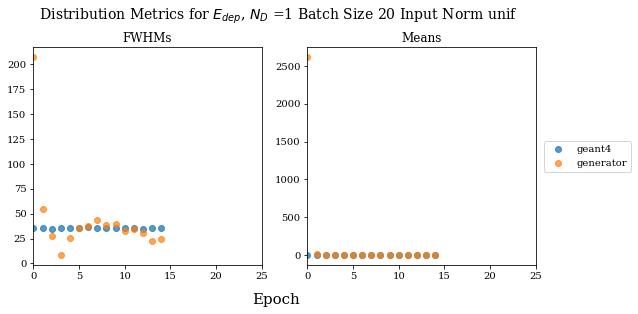

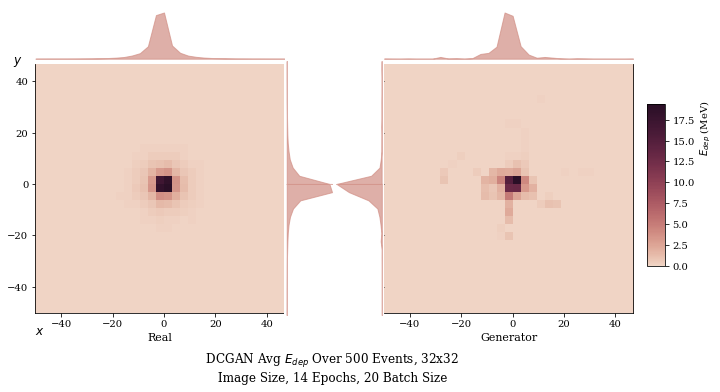

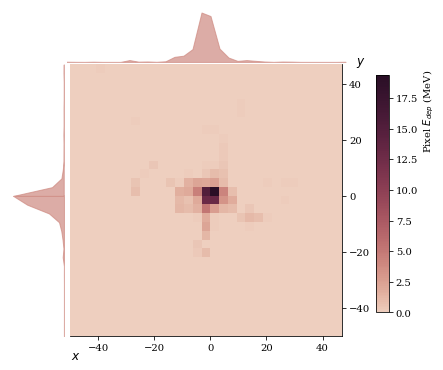

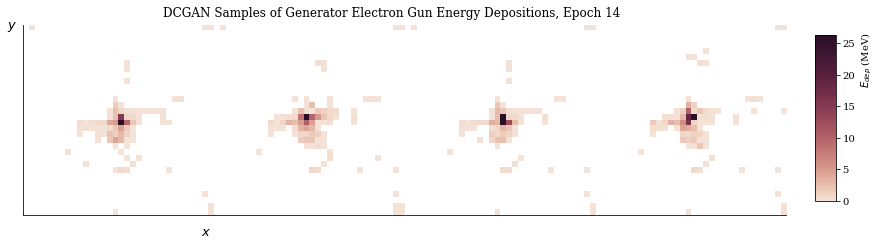

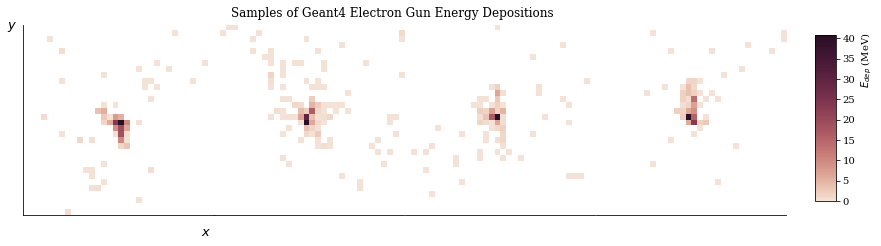

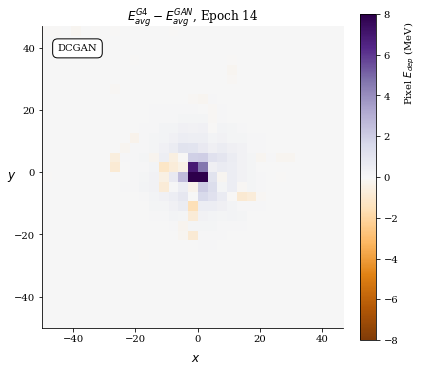

[14/50][0/1500] Loss_D: 0.0213 Loss_G: 5.8687 D(x): 0.9968 D(G(z)): 0.0048 / 0.0037
[14/50][100/1500] Loss_D: 0.0289 Loss_G: 6.8625 D(x): 0.9874 D(G(z)): 0.0036 / 0.0033
[14/50][200/1500] Loss_D: 0.6885 Loss_G: 0.9580 D(x): 0.6881 D(G(z)): 0.0072 / 0.4282
[14/50][300/1500] Loss_D: 0.4793 Loss_G: 1.3754 D(x): 0.7338 D(G(z)): 0.0205 / 0.2917
[14/50][400/1500] Loss_D: 0.1183 Loss_G: 4.4581 D(x): 0.9984 D(G(z)): 0.0927 / 0.0201
[14/50][500/1500] Loss_D: 0.0566 Loss_G: 5.7001 D(x): 0.9632 D(G(z)): 0.0051 / 0.0047
[14/50][600/1500] Loss_D: 0.0899 Loss_G: 5.4111 D(x): 0.9993 D(G(z)): 0.0694 / 0.0058
[14/50][700/1500] Loss_D: 0.1317 Loss_G: 3.3223 D(x): 0.9562 D(G(z)): 0.0732 / 0.0450
[14/50][800/1500] Loss_D: 0.0294 Loss_G: 5.3478 D(x): 0.9929 D(G(z)): 0.0091 / 0.0077
[14/50][900/1500] Loss_D: 1.0153 Loss_G: 13.1564 D(x): 0.9666 D(G(z)): 0.5663 / 0.0000
[14/50][1000/1500] Loss_D: 0.3077 Loss_G: 6.1933 D(x): 0.9957 D(G(z)): 0.2221 / 0.0038
[14/50][1100/1500] Loss_D: 0.3988 Loss_G: 1.6555 D(x):

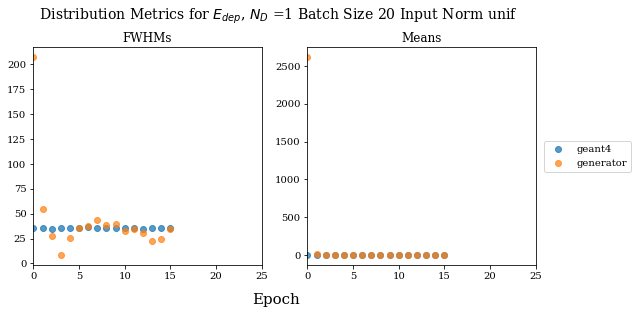

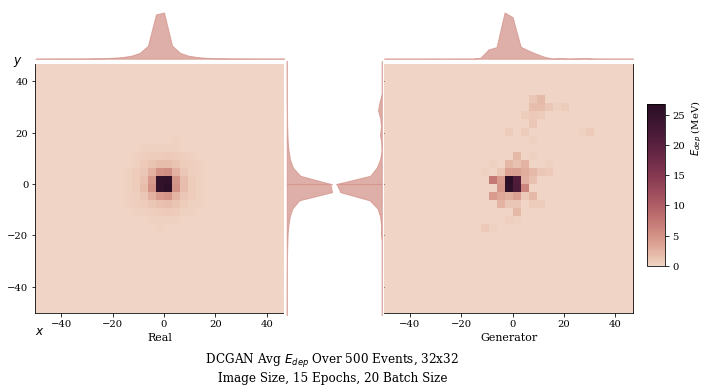

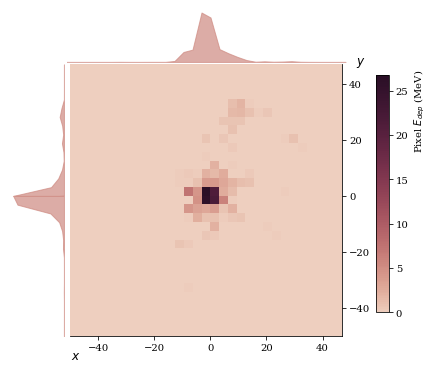

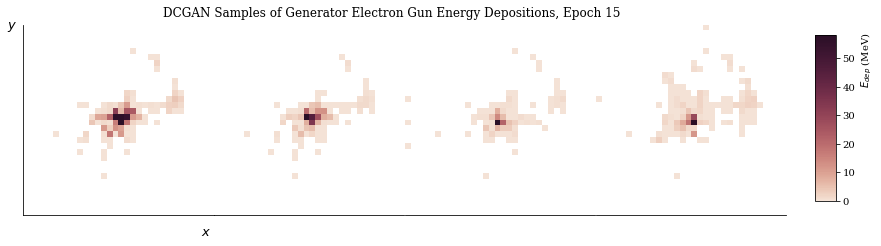

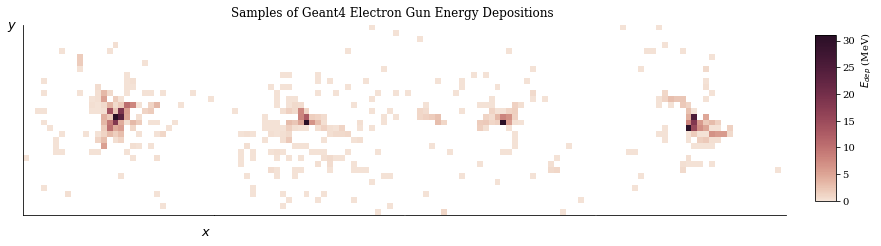

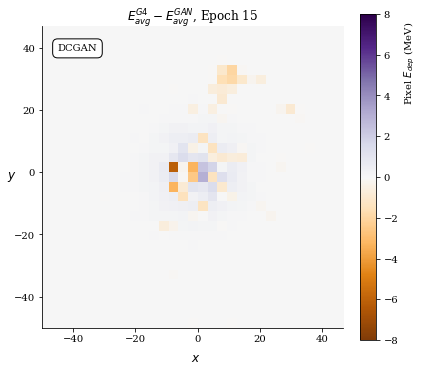

[15/50][0/1500] Loss_D: 0.0468 Loss_G: 4.9322 D(x): 0.9851 D(G(z)): 0.0183 / 0.0092
[15/50][100/1500] Loss_D: 0.0605 Loss_G: 4.3463 D(x): 0.9657 D(G(z)): 0.0073 / 0.0183
[15/50][200/1500] Loss_D: 0.0717 Loss_G: 4.7222 D(x): 0.9579 D(G(z)): 0.0158 / 0.0172
[15/50][300/1500] Loss_D: 0.6901 Loss_G: 3.1936 D(x): 0.6066 D(G(z)): 0.0046 / 0.0791
[15/50][400/1500] Loss_D: 0.1877 Loss_G: 5.6350 D(x): 0.9933 D(G(z)): 0.1419 / 0.0078
[15/50][500/1500] Loss_D: 0.3412 Loss_G: 2.0548 D(x): 0.7818 D(G(z)): 0.0197 / 0.1508
[15/50][600/1500] Loss_D: 0.0298 Loss_G: 4.6787 D(x): 0.9994 D(G(z)): 0.0132 / 0.0115
[15/50][700/1500] Loss_D: 0.1075 Loss_G: 4.6798 D(x): 0.9262 D(G(z)): 0.0111 / 0.0112
[15/50][800/1500] Loss_D: 0.0950 Loss_G: 5.1939 D(x): 0.9622 D(G(z)): 0.0434 / 0.0100
[15/50][900/1500] Loss_D: 0.0312 Loss_G: 5.7254 D(x): 0.9907 D(G(z)): 0.0072 / 0.0050
[15/50][1000/1500] Loss_D: 0.0367 Loss_G: 5.5656 D(x): 0.9986 D(G(z)): 0.0200 / 0.0048
[15/50][1100/1500] Loss_D: 0.0222 Loss_G: 6.2230 D(x): 

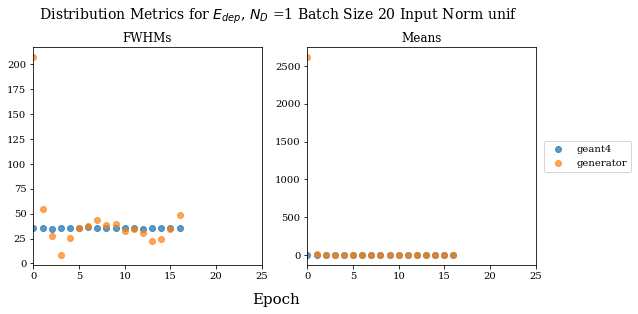

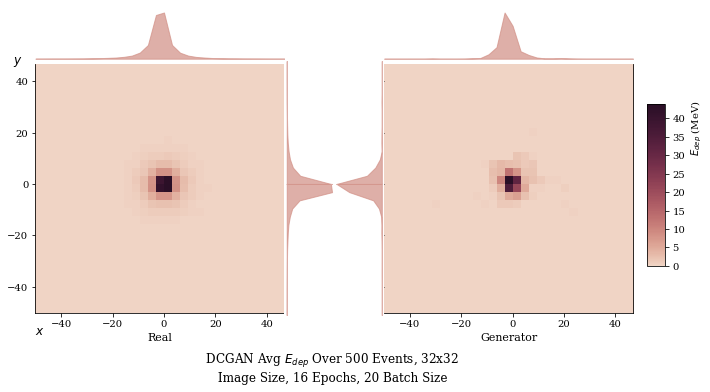

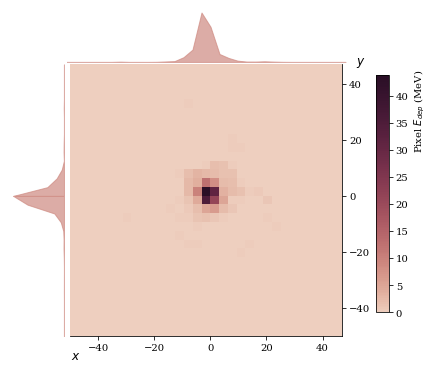

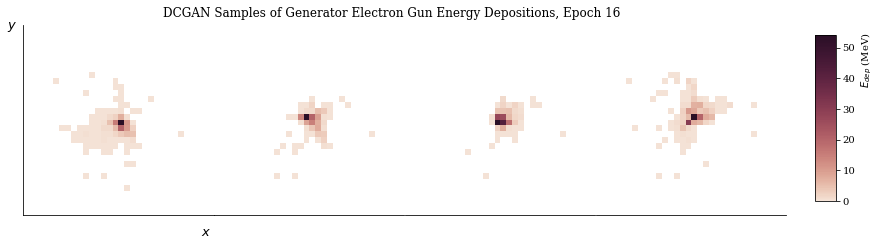

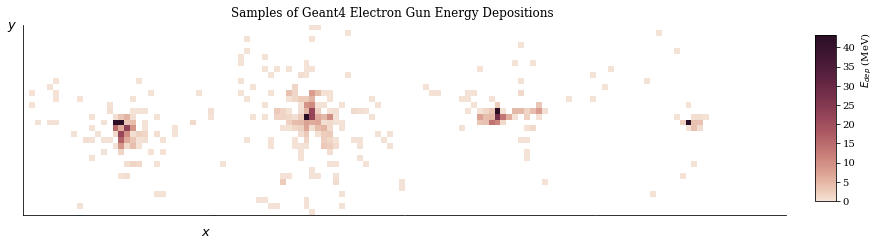

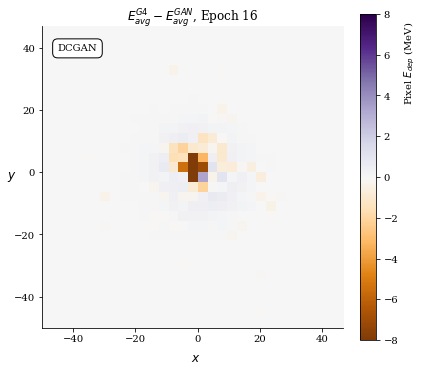

[16/50][0/1500] Loss_D: 5.2865 Loss_G: 2.3591 D(x): 0.9821 D(G(z)): 0.9820 / 0.1937
[16/50][100/1500] Loss_D: 0.0835 Loss_G: 4.6311 D(x): 0.9641 D(G(z)): 0.0339 / 0.0237
[16/50][200/1500] Loss_D: 0.0483 Loss_G: 5.3964 D(x): 0.9790 D(G(z)): 0.0120 / 0.0057
[16/50][300/1500] Loss_D: 0.1437 Loss_G: 3.2695 D(x): 0.9448 D(G(z)): 0.0596 / 0.0483
[16/50][400/1500] Loss_D: 0.0318 Loss_G: 4.8444 D(x): 0.9950 D(G(z)): 0.0147 / 0.0102
[16/50][500/1500] Loss_D: 0.0738 Loss_G: 4.6296 D(x): 0.9501 D(G(z)): 0.0095 / 0.0130
[16/50][600/1500] Loss_D: 0.0216 Loss_G: 6.4182 D(x): 0.9969 D(G(z)): 0.0040 / 0.0025
[16/50][700/1500] Loss_D: 0.1697 Loss_G: 4.3034 D(x): 0.9626 D(G(z)): 0.1107 / 0.0167
[16/50][800/1500] Loss_D: 0.0460 Loss_G: 5.3736 D(x): 0.9824 D(G(z)): 0.0135 / 0.0078
[16/50][900/1500] Loss_D: 0.0655 Loss_G: 4.6536 D(x): 0.9961 D(G(z)): 0.0450 / 0.0210
[16/50][1000/1500] Loss_D: 0.1870 Loss_G: 6.1055 D(x): 0.9833 D(G(z)): 0.1419 / 0.0032
[16/50][1100/1500] Loss_D: 0.2298 Loss_G: 0.9866 D(x): 

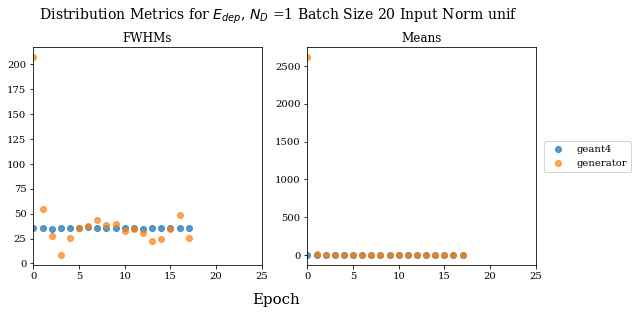

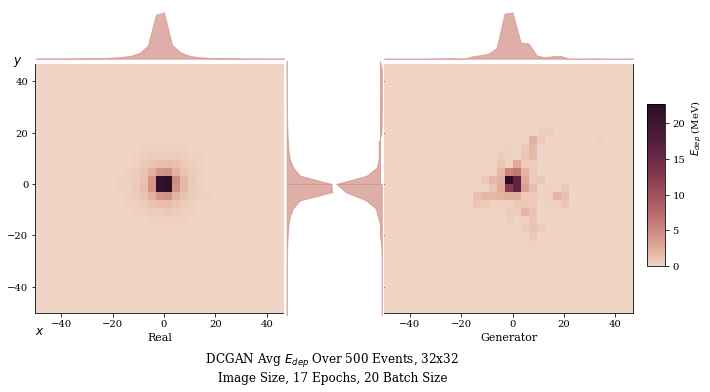

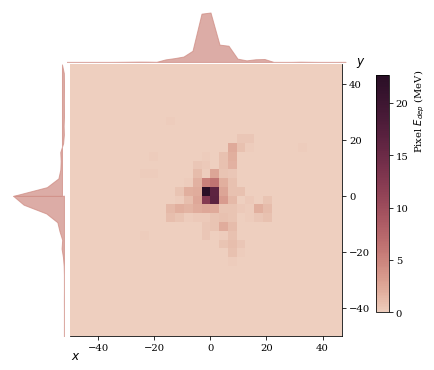

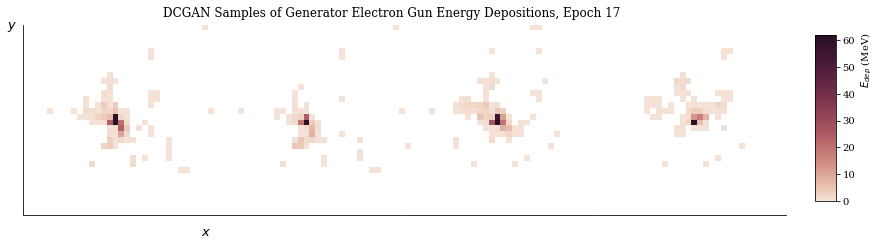

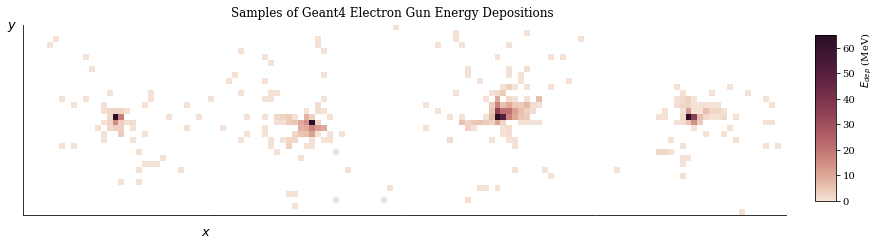

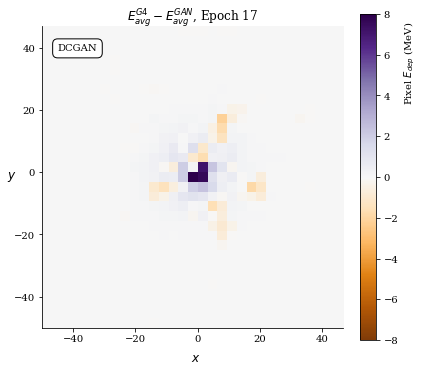

[17/50][0/1500] Loss_D: 0.0345 Loss_G: 5.8749 D(x): 0.9863 D(G(z)): 0.0049 / 0.0036
[17/50][100/1500] Loss_D: 0.1283 Loss_G: 6.7202 D(x): 0.9229 D(G(z)): 0.0028 / 0.0064
[17/50][200/1500] Loss_D: 0.2978 Loss_G: 7.0438 D(x): 0.9981 D(G(z)): 0.2143 / 0.0019
[17/50][300/1500] Loss_D: 0.1743 Loss_G: 3.5483 D(x): 0.8756 D(G(z)): 0.0165 / 0.0378
[17/50][400/1500] Loss_D: 0.0524 Loss_G: 5.7347 D(x): 0.9972 D(G(z)): 0.0357 / 0.0061
[17/50][500/1500] Loss_D: 0.2972 Loss_G: 3.2063 D(x): 0.9041 D(G(z)): 0.1643 / 0.0480
[17/50][600/1500] Loss_D: 0.0474 Loss_G: 5.8505 D(x): 0.9781 D(G(z)): 0.0063 / 0.0041
[17/50][700/1500] Loss_D: 0.2421 Loss_G: 3.7718 D(x): 0.9067 D(G(z)): 0.0892 / 0.0363
[17/50][800/1500] Loss_D: 0.0967 Loss_G: 9.4359 D(x): 0.9378 D(G(z)): 0.0000 / 0.0002
[17/50][900/1500] Loss_D: 0.0986 Loss_G: 5.9649 D(x): 0.9994 D(G(z)): 0.0767 / 0.0067
[17/50][1000/1500] Loss_D: 0.0427 Loss_G: 6.3689 D(x): 0.9790 D(G(z)): 0.0021 / 0.0024
[17/50][1100/1500] Loss_D: 0.4809 Loss_G: 6.6450 D(x): 

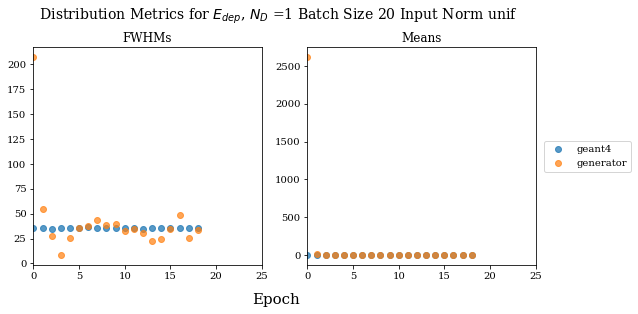

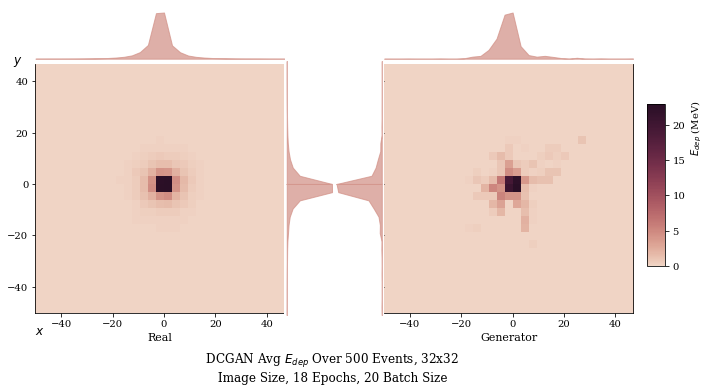

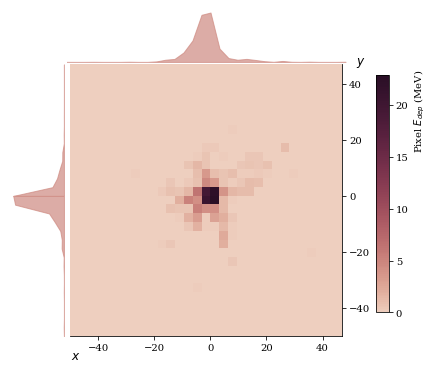

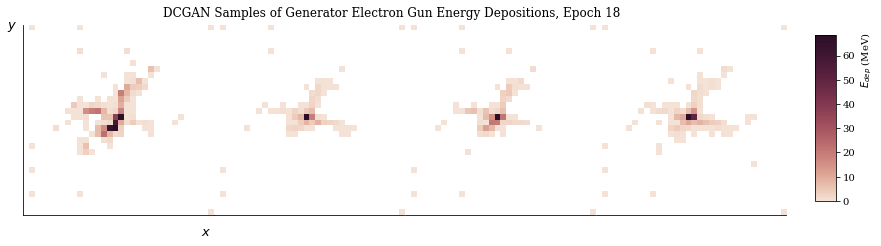

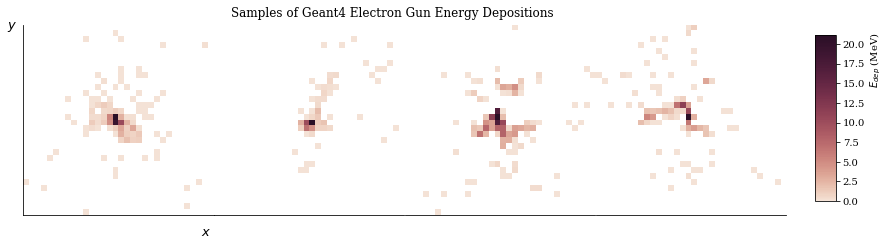

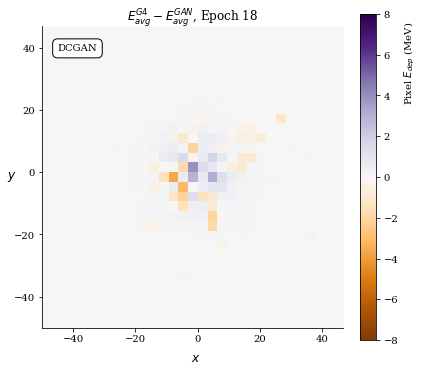

[18/50][0/1500] Loss_D: 0.0719 Loss_G: 5.9557 D(x): 0.9539 D(G(z)): 0.0094 / 0.0056
[18/50][100/1500] Loss_D: 0.0942 Loss_G: 6.4367 D(x): 0.9273 D(G(z)): 0.0013 / 0.0029
[18/50][200/1500] Loss_D: 0.1801 Loss_G: 4.5902 D(x): 0.9157 D(G(z)): 0.0556 / 0.0221
[18/50][300/1500] Loss_D: 0.0480 Loss_G: 5.9927 D(x): 0.9960 D(G(z)): 0.0304 / 0.0037
[18/50][400/1500] Loss_D: 0.0571 Loss_G: 5.7125 D(x): 0.9898 D(G(z)): 0.0306 / 0.0051
[18/50][500/1500] Loss_D: 0.0453 Loss_G: 8.9088 D(x): 0.9818 D(G(z)): 0.0111 / 0.0172
[18/50][600/1500] Loss_D: 0.0239 Loss_G: 6.1458 D(x): 0.9922 D(G(z)): 0.0020 / 0.0029
[18/50][700/1500] Loss_D: 0.0532 Loss_G: 4.7573 D(x): 0.9927 D(G(z)): 0.0320 / 0.0128
[18/50][800/1500] Loss_D: 0.1225 Loss_G: 5.9788 D(x): 0.9169 D(G(z)): 0.0039 / 0.0056
[18/50][900/1500] Loss_D: 0.0252 Loss_G: 8.1837 D(x): 0.9964 D(G(z)): 0.0003 / 0.0004
[18/50][1000/1500] Loss_D: 0.0519 Loss_G: 4.7206 D(x): 0.9984 D(G(z)): 0.0346 / 0.0115
[18/50][1100/1500] Loss_D: 0.0244 Loss_G: 6.7685 D(x): 

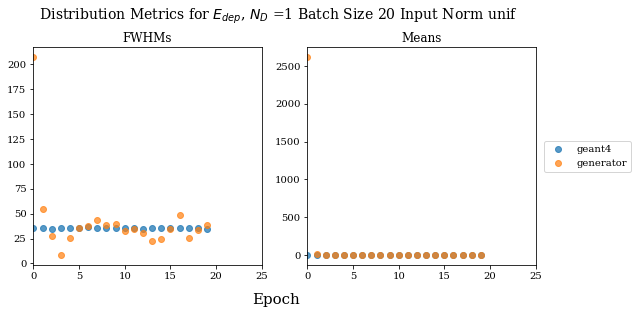

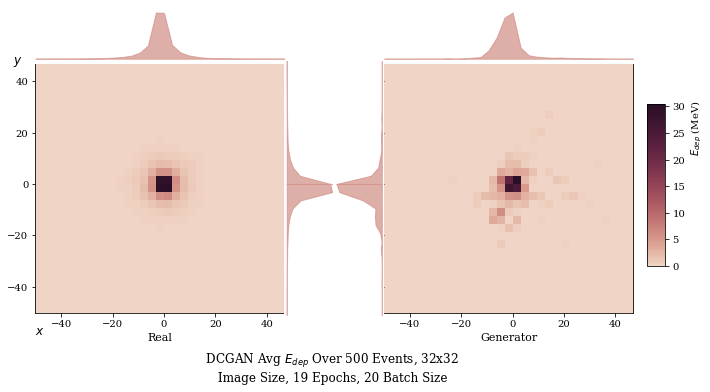

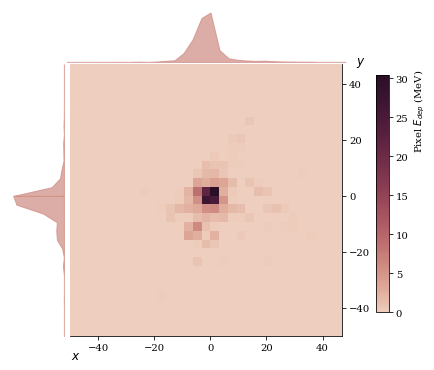

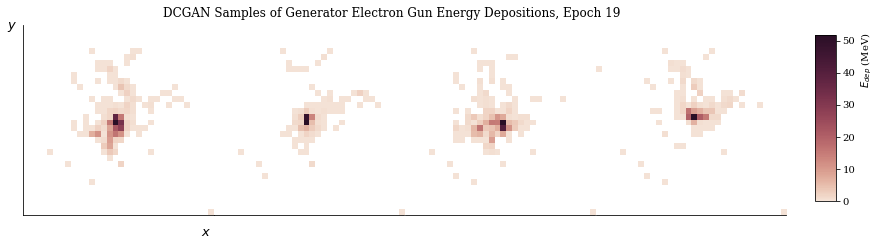

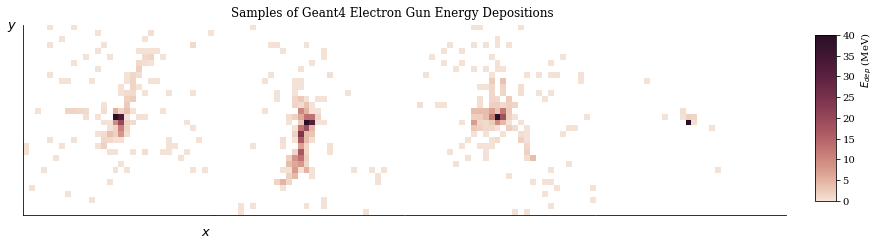

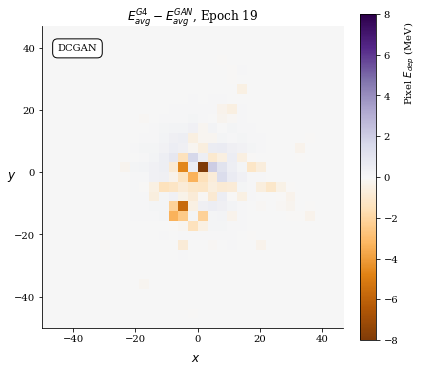

[19/50][0/1500] Loss_D: 0.1678 Loss_G: 7.0940 D(x): 0.9504 D(G(z)): 0.0763 / 0.0013
[19/50][100/1500] Loss_D: 0.0760 Loss_G: 5.3866 D(x): 0.9428 D(G(z)): 0.0043 / 0.0057
[19/50][200/1500] Loss_D: 0.1340 Loss_G: 4.6814 D(x): 0.9337 D(G(z)): 0.0431 / 0.0160
[19/50][300/1500] Loss_D: 0.0729 Loss_G: 7.5408 D(x): 0.9477 D(G(z)): 0.0006 / 0.0007
[19/50][400/1500] Loss_D: 0.1984 Loss_G: 5.3448 D(x): 0.9753 D(G(z)): 0.1302 / 0.0061
[19/50][500/1500] Loss_D: 0.0784 Loss_G: 3.8788 D(x): 0.9927 D(G(z)): 0.0590 / 0.0262
[19/50][600/1500] Loss_D: 0.0481 Loss_G: 4.8358 D(x): 0.9986 D(G(z)): 0.0336 / 0.0120
[19/50][700/1500] Loss_D: 0.0900 Loss_G: 5.4056 D(x): 0.9444 D(G(z)): 0.0138 / 0.0082
[19/50][800/1500] Loss_D: 0.0653 Loss_G: 6.8721 D(x): 0.9615 D(G(z)): 0.0027 / 0.0017
[19/50][900/1500] Loss_D: 0.0477 Loss_G: 4.6485 D(x): 0.9990 D(G(z)): 0.0316 / 0.0137
[19/50][1000/1500] Loss_D: 0.4511 Loss_G: 12.0643 D(x): 0.9999 D(G(z)): 0.3112 / 0.0000
[19/50][1100/1500] Loss_D: 0.4489 Loss_G: 9.0002 D(x):

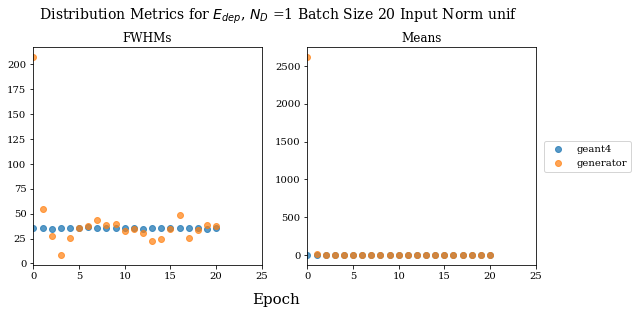

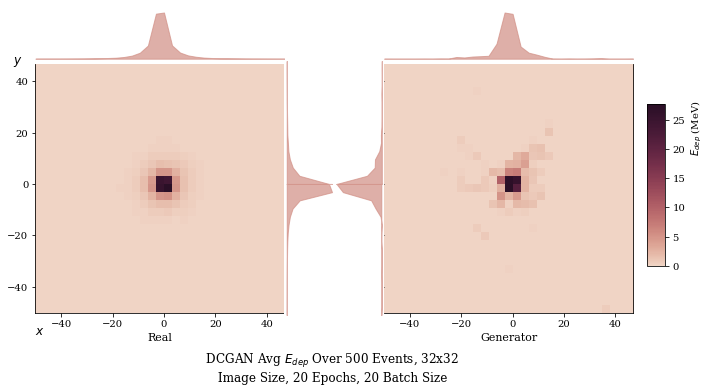

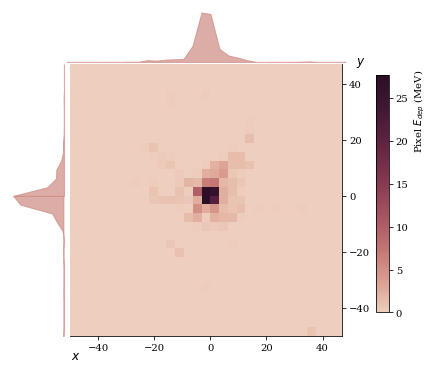

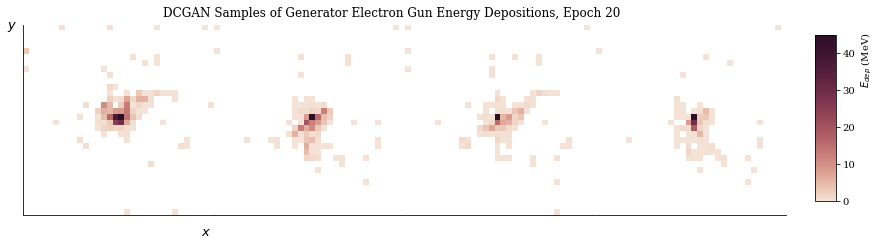

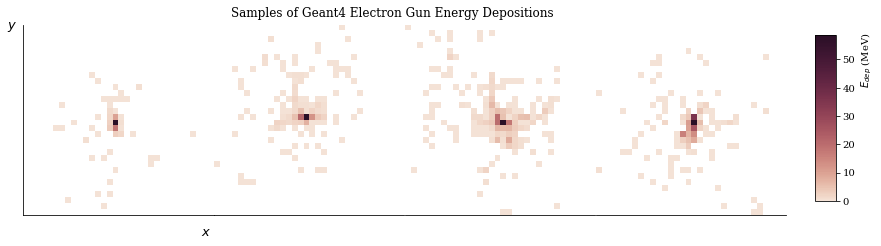

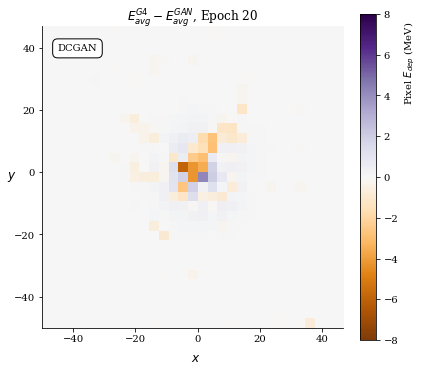

[20/50][0/1500] Loss_D: 0.0281 Loss_G: 5.4365 D(x): 0.9981 D(G(z)): 0.0106 / 0.0062
[20/50][100/1500] Loss_D: 0.1974 Loss_G: 5.2068 D(x): 0.8710 D(G(z)): 0.0126 / 0.0125
[20/50][200/1500] Loss_D: 0.3101 Loss_G: 9.6519 D(x): 0.8327 D(G(z)): 0.0000 / 0.0002
[20/50][300/1500] Loss_D: 0.1583 Loss_G: 4.8263 D(x): 0.8894 D(G(z)): 0.0038 / 0.0109
[20/50][400/1500] Loss_D: 0.0412 Loss_G: 4.4339 D(x): 0.9999 D(G(z)): 0.0227 / 0.0157
[20/50][500/1500] Loss_D: 0.2179 Loss_G: 7.5988 D(x): 0.9945 D(G(z)): 0.1737 / 0.0014
[20/50][600/1500] Loss_D: 0.0279 Loss_G: 6.8789 D(x): 0.9984 D(G(z)): 0.0106 / 0.0016
[20/50][700/1500] Loss_D: 0.0676 Loss_G: 5.2666 D(x): 0.9999 D(G(z)): 0.0497 / 0.0075
[20/50][800/1500] Loss_D: 0.0898 Loss_G: 4.5249 D(x): 0.9721 D(G(z)): 0.0509 / 0.0171
[20/50][900/1500] Loss_D: 0.1019 Loss_G: 5.2615 D(x): 0.9991 D(G(z)): 0.0821 / 0.0073
[20/50][1000/1500] Loss_D: 0.1558 Loss_G: 5.8725 D(x): 0.9870 D(G(z)): 0.0914 / 0.0063
[20/50][1100/1500] Loss_D: 0.5236 Loss_G: 1.1316 D(x): 

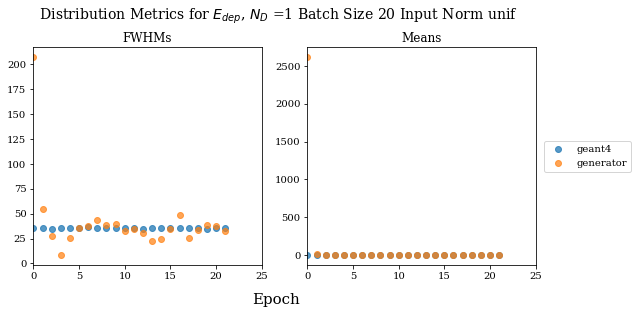

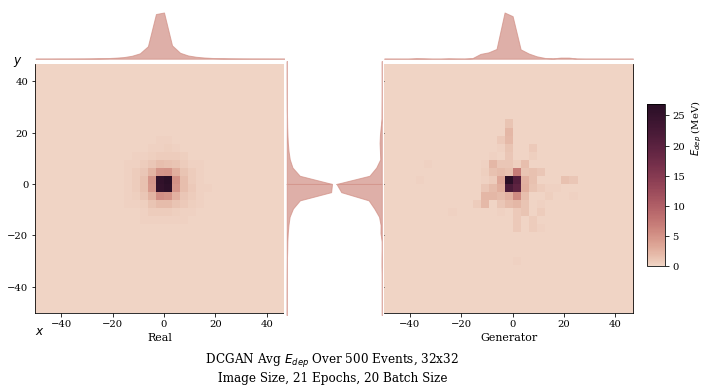

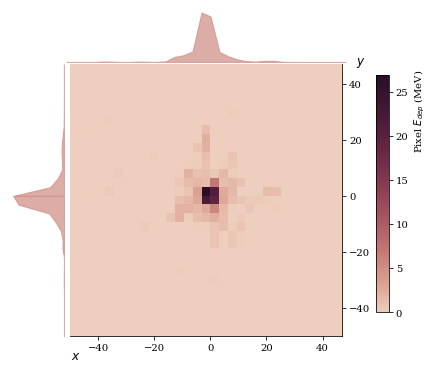

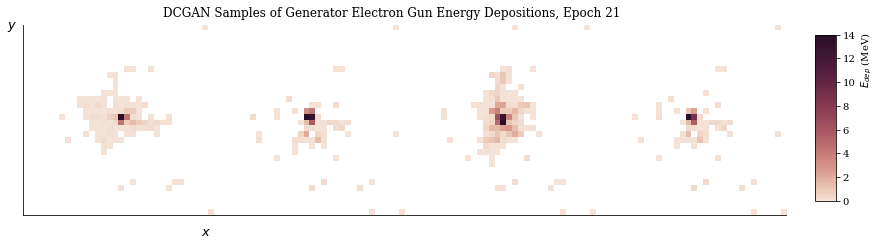

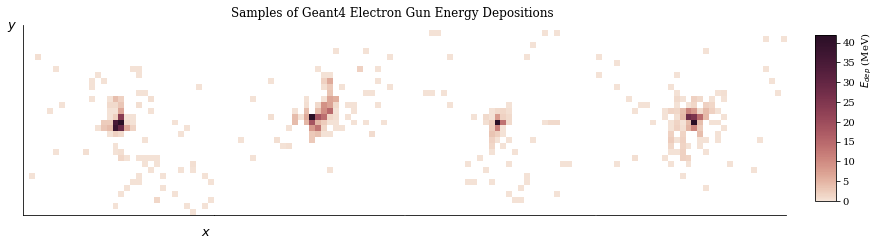

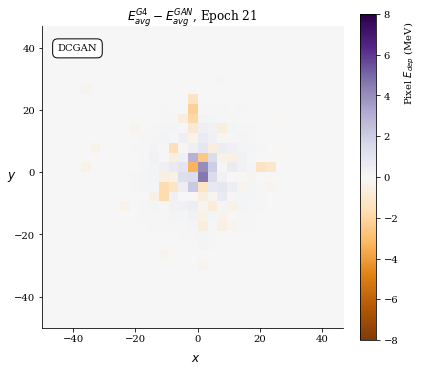

[21/50][0/1500] Loss_D: 0.0423 Loss_G: 5.2949 D(x): 0.9798 D(G(z)): 0.0083 / 0.0064
[21/50][100/1500] Loss_D: 0.0799 Loss_G: 4.9707 D(x): 0.9439 D(G(z)): 0.0028 / 0.0089
[21/50][200/1500] Loss_D: 0.0740 Loss_G: 4.2337 D(x): 0.9523 D(G(z)): 0.0105 / 0.0205
[21/50][300/1500] Loss_D: 0.0426 Loss_G: 5.0729 D(x): 0.9882 D(G(z)): 0.0178 / 0.0086
[21/50][400/1500] Loss_D: 0.0642 Loss_G: 4.9471 D(x): 0.9999 D(G(z)): 0.0432 / 0.0137
[21/50][500/1500] Loss_D: 0.0236 Loss_G: 5.9820 D(x): 0.9980 D(G(z)): 0.0063 / 0.0032
[21/50][600/1500] Loss_D: 0.0246 Loss_G: 7.1008 D(x): 1.0000 D(G(z)): 0.0026 / 0.0033
[21/50][700/1500] Loss_D: 0.2059 Loss_G: 5.0649 D(x): 0.9017 D(G(z)): 0.0543 / 0.0212
[21/50][800/1500] Loss_D: 0.2431 Loss_G: 3.8563 D(x): 0.8817 D(G(z)): 0.0091 / 0.0677
[21/50][900/1500] Loss_D: 0.0262 Loss_G: 6.2073 D(x): 0.9988 D(G(z)): 0.0083 / 0.0055
[21/50][1000/1500] Loss_D: 0.1516 Loss_G: 4.6927 D(x): 0.9484 D(G(z)): 0.0520 / 0.0158
[21/50][1100/1500] Loss_D: 0.1245 Loss_G: 7.8109 D(x): 

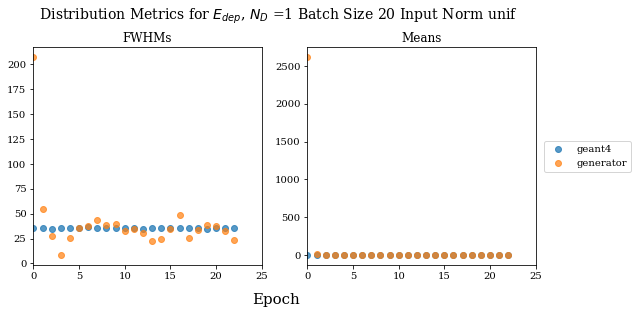

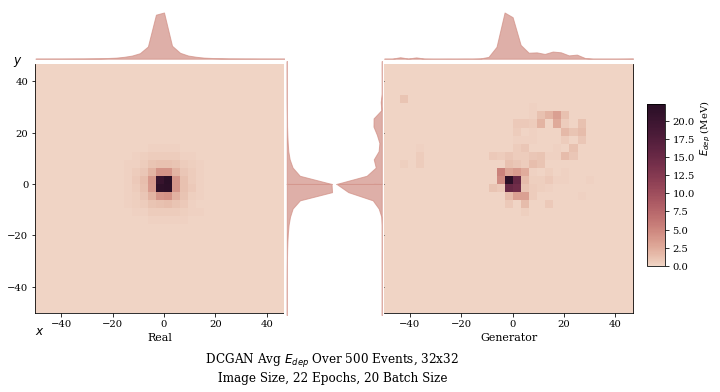

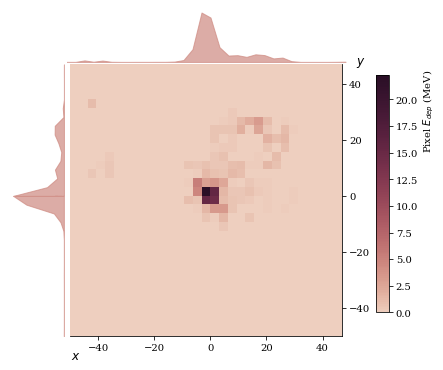

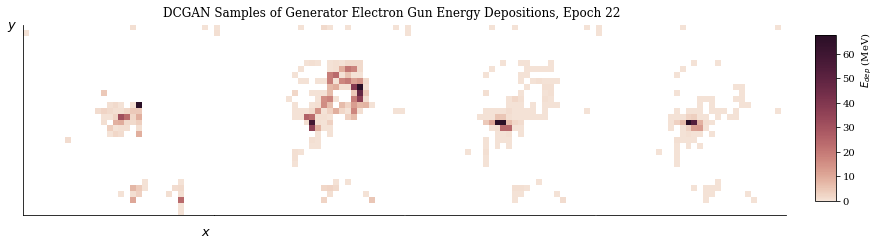

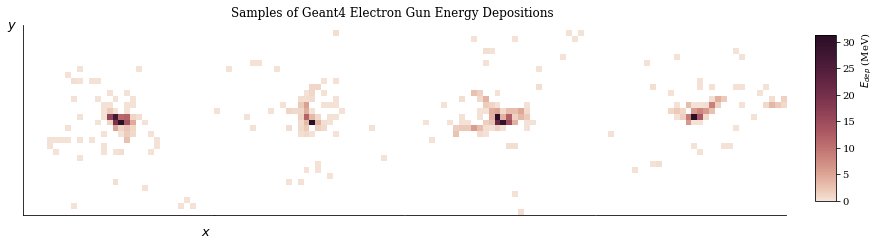

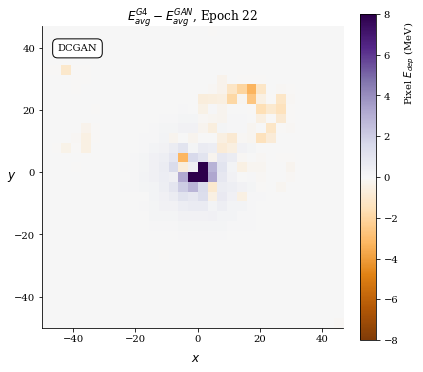

[22/50][0/1500] Loss_D: 0.0268 Loss_G: 5.5648 D(x): 0.9992 D(G(z)): 0.0098 / 0.0049
[22/50][100/1500] Loss_D: 0.0524 Loss_G: 5.2072 D(x): 0.9692 D(G(z)): 0.0074 / 0.0088
[22/50][200/1500] Loss_D: 0.0315 Loss_G: 6.9065 D(x): 0.9845 D(G(z)): 0.0015 / 0.0017
[22/50][300/1500] Loss_D: 0.0343 Loss_G: 5.3664 D(x): 0.9962 D(G(z)): 0.0164 / 0.0065
[22/50][400/1500] Loss_D: 0.0330 Loss_G: 6.6011 D(x): 0.9999 D(G(z)): 0.0127 / 0.0037
[22/50][500/1500] Loss_D: 0.0662 Loss_G: 4.4393 D(x): 0.9957 D(G(z)): 0.0457 / 0.0180
[22/50][600/1500] Loss_D: 0.0390 Loss_G: 5.0389 D(x): 1.0000 D(G(z)): 0.0185 / 0.0090
[22/50][700/1500] Loss_D: 0.0325 Loss_G: 5.4717 D(x): 0.9901 D(G(z)): 0.0076 / 0.0076
[22/50][800/1500] Loss_D: 0.0245 Loss_G: 9.4313 D(x): 0.9957 D(G(z)): 0.0001 / 0.0001
[22/50][900/1500] Loss_D: 0.0369 Loss_G: 11.3361 D(x): 0.9853 D(G(z)): 0.0001 / 0.0000
[22/50][1000/1500] Loss_D: 0.2708 Loss_G: 7.3659 D(x): 0.9990 D(G(z)): 0.1983 / 0.0012
[22/50][1100/1500] Loss_D: 0.9423 Loss_G: 8.5021 D(x):

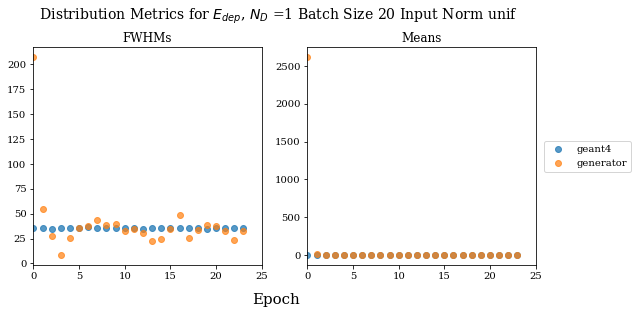

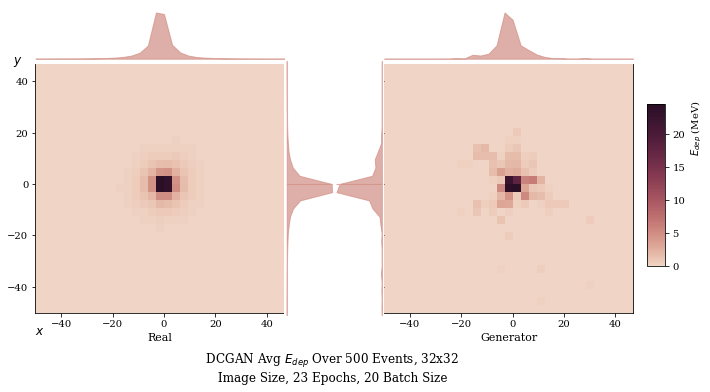

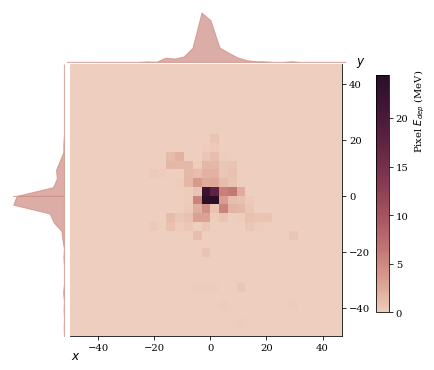

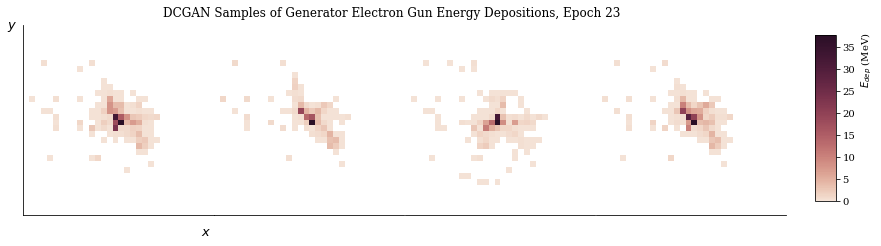

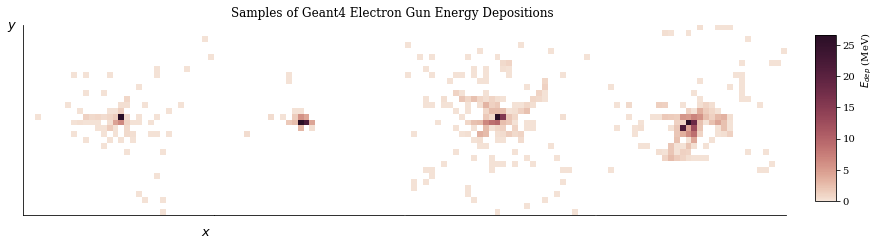

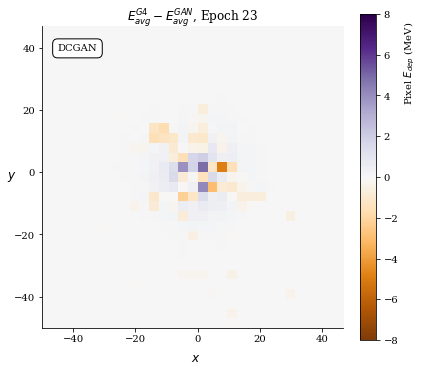

[23/50][0/1500] Loss_D: 0.0588 Loss_G: 5.5143 D(x): 0.9950 D(G(z)): 0.0398 / 0.0125
[23/50][100/1500] Loss_D: 0.2869 Loss_G: 3.8154 D(x): 0.8043 D(G(z)): 0.0027 / 0.0532
[23/50][200/1500] Loss_D: 0.2161 Loss_G: 3.6743 D(x): 0.9022 D(G(z)): 0.0112 / 0.0331
[23/50][300/1500] Loss_D: 0.2166 Loss_G: 3.6785 D(x): 0.8747 D(G(z)): 0.0323 / 0.0345
[23/50][400/1500] Loss_D: 0.1504 Loss_G: 6.8242 D(x): 0.9997 D(G(z)): 0.1270 / 0.0012
[23/50][500/1500] Loss_D: 0.0257 Loss_G: 5.9864 D(x): 0.9993 D(G(z)): 0.0105 / 0.0051
[23/50][600/1500] Loss_D: 0.0897 Loss_G: 5.5231 D(x): 1.0000 D(G(z)): 0.0684 / 0.0092
[23/50][700/1500] Loss_D: 0.0850 Loss_G: 5.0770 D(x): 0.9856 D(G(z)): 0.0585 / 0.0078
[23/50][800/1500] Loss_D: 0.2148 Loss_G: 5.5381 D(x): 0.9427 D(G(z)): 0.0085 / 0.0140
[23/50][900/1500] Loss_D: 0.0832 Loss_G: 8.4332 D(x): 0.9409 D(G(z)): 0.0028 / 0.0003
[23/50][1000/1500] Loss_D: 0.1556 Loss_G: 5.8839 D(x): 0.9137 D(G(z)): 0.0283 / 0.0053
[23/50][1100/1500] Loss_D: 0.0647 Loss_G: 4.7346 D(x): 

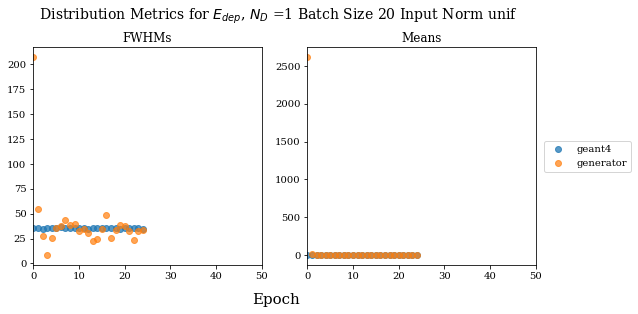

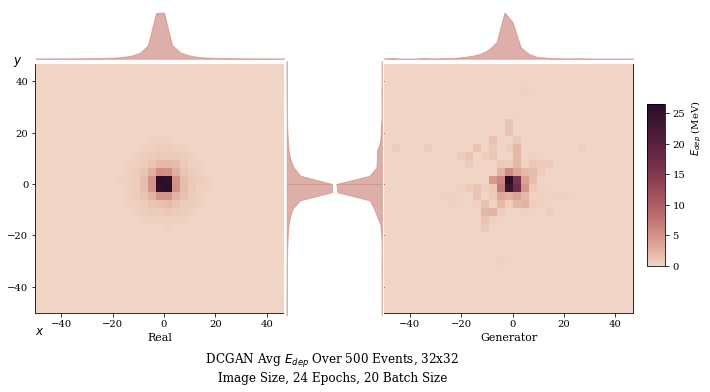

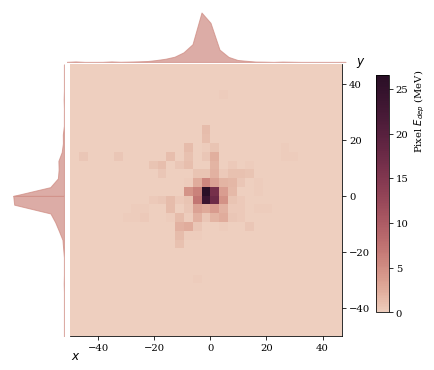

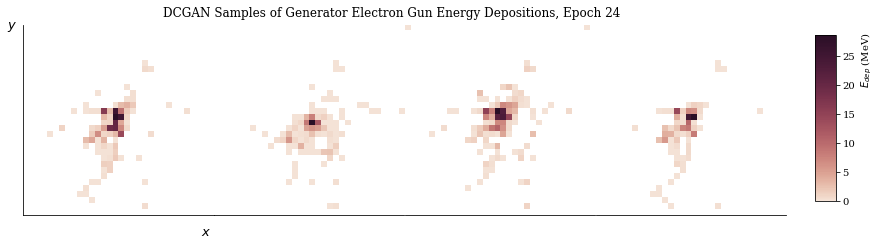

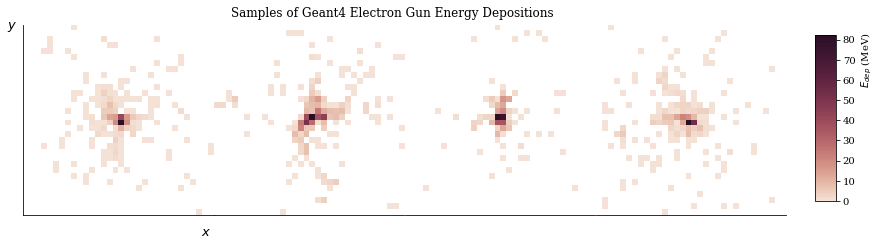

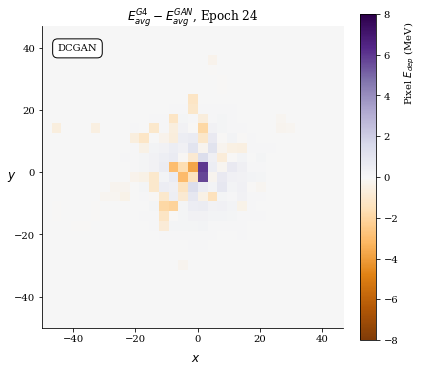

[24/50][0/1500] Loss_D: 0.1243 Loss_G: 5.4276 D(x): 0.9659 D(G(z)): 0.0753 / 0.0054
[24/50][100/1500] Loss_D: 0.0612 Loss_G: 2.9664 D(x): 0.9998 D(G(z)): 0.0440 / 0.0705
[24/50][200/1500] Loss_D: 0.2404 Loss_G: 11.2186 D(x): 0.8387 D(G(z)): 0.0000 / 0.0000
[24/50][300/1500] Loss_D: 0.0561 Loss_G: 4.8107 D(x): 0.9851 D(G(z)): 0.0309 / 0.0104
[24/50][400/1500] Loss_D: 0.0537 Loss_G: 4.1076 D(x): 0.9807 D(G(z)): 0.0154 / 0.0196
[24/50][500/1500] Loss_D: 0.1483 Loss_G: 3.8571 D(x): 0.9147 D(G(z)): 0.0321 / 0.0376
[24/50][600/1500] Loss_D: 0.0367 Loss_G: 4.5565 D(x): 0.9997 D(G(z)): 0.0198 / 0.0137
[24/50][700/1500] Loss_D: 0.3931 Loss_G: 4.0683 D(x): 0.7931 D(G(z)): 0.0062 / 0.0267
[24/50][800/1500] Loss_D: 0.1903 Loss_G: 4.9872 D(x): 0.9496 D(G(z)): 0.0112 / 0.0095
[24/50][900/1500] Loss_D: 0.0230 Loss_G: 5.9345 D(x): 0.9990 D(G(z)): 0.0050 / 0.0033
[24/50][1000/1500] Loss_D: 0.0778 Loss_G: 3.8933 D(x): 0.9506 D(G(z)): 0.0120 / 0.0270
[24/50][1100/1500] Loss_D: 0.0394 Loss_G: 4.8422 D(x):

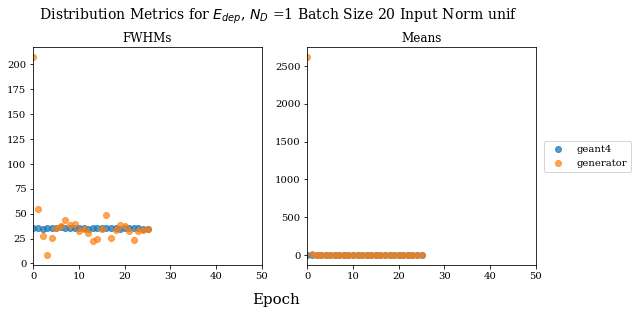

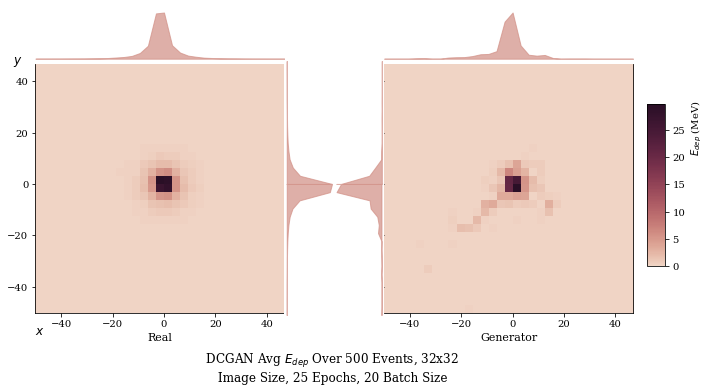

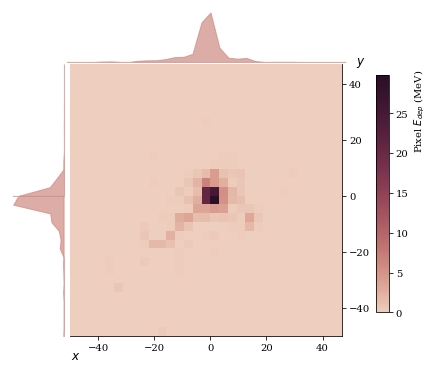

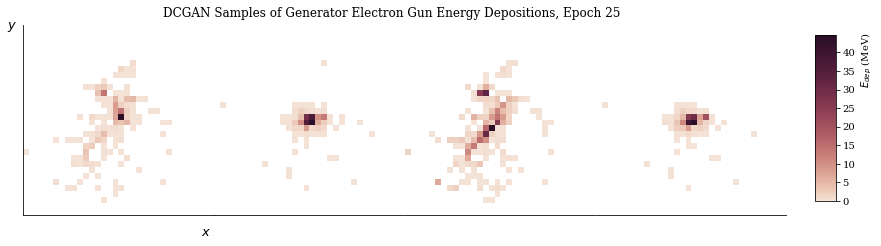

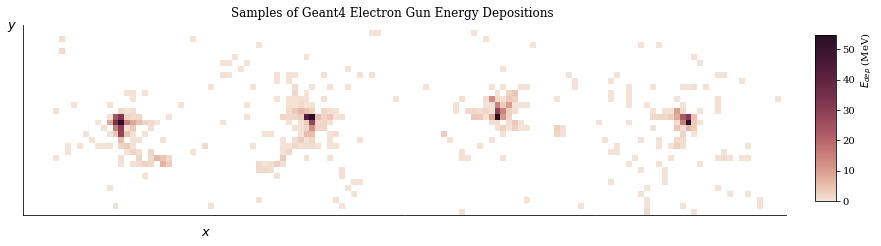

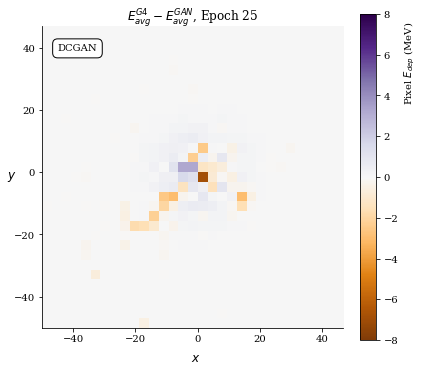

[25/50][0/1500] Loss_D: 0.1050 Loss_G: 5.8536 D(x): 0.9959 D(G(z)): 0.0813 / 0.0075
[25/50][100/1500] Loss_D: 0.2357 Loss_G: 5.0215 D(x): 0.8587 D(G(z)): 0.0024 / 0.0152
[25/50][200/1500] Loss_D: 0.0503 Loss_G: 4.7586 D(x): 0.9859 D(G(z)): 0.0242 / 0.0117
[25/50][300/1500] Loss_D: 0.3242 Loss_G: 7.0370 D(x): 0.9483 D(G(z)): 0.2182 / 0.0012
[25/50][400/1500] Loss_D: 0.0685 Loss_G: 5.7034 D(x): 0.9998 D(G(z)): 0.0404 / 0.0438
[25/50][500/1500] Loss_D: 0.1741 Loss_G: 5.5943 D(x): 0.9633 D(G(z)): 0.1032 / 0.0113
[25/50][600/1500] Loss_D: 0.0259 Loss_G: 7.6267 D(x): 0.9990 D(G(z)): 0.0056 / 0.0017
[25/50][700/1500] Loss_D: 0.1002 Loss_G: 4.6981 D(x): 0.9265 D(G(z)): 0.0060 / 0.0138
[25/50][800/1500] Loss_D: 0.4137 Loss_G: 4.1221 D(x): 0.8675 D(G(z)): 0.0064 / 0.0478
[25/50][900/1500] Loss_D: 0.1469 Loss_G: 4.1852 D(x): 0.9418 D(G(z)): 0.0346 / 0.0183
[25/50][1000/1500] Loss_D: 0.0428 Loss_G: 4.7332 D(x): 0.9963 D(G(z)): 0.0263 / 0.0103
[25/50][1100/1500] Loss_D: 0.1168 Loss_G: 3.6721 D(x): 

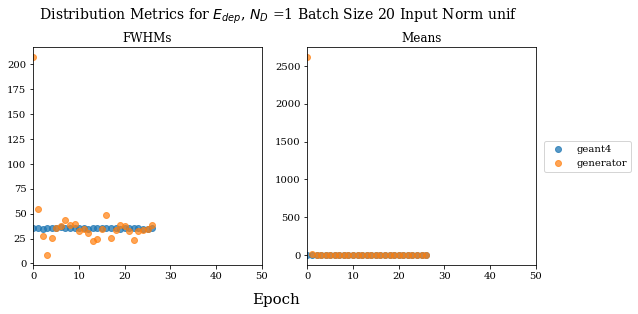

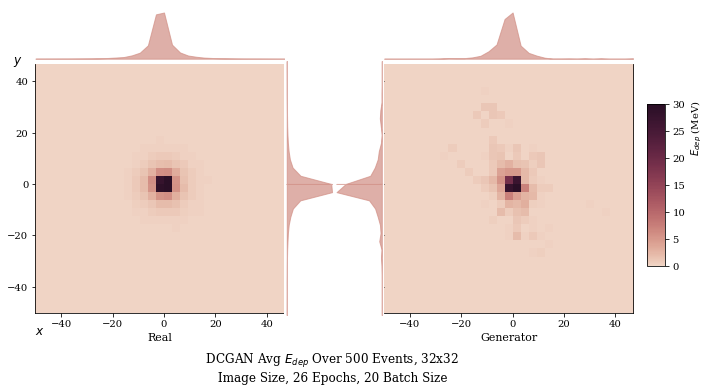

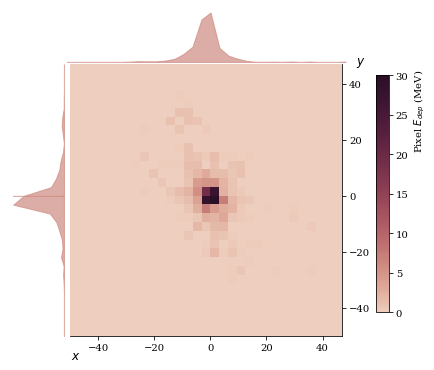

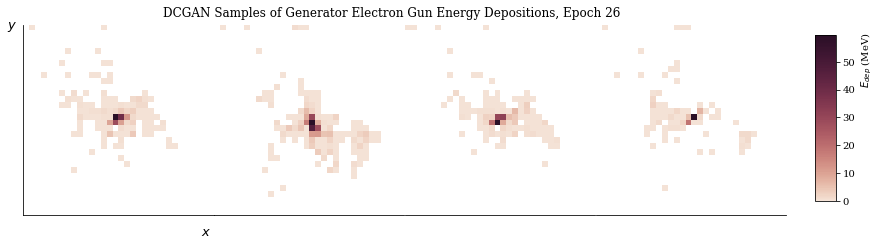

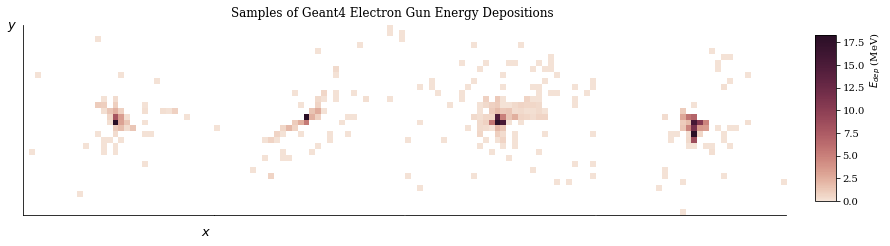

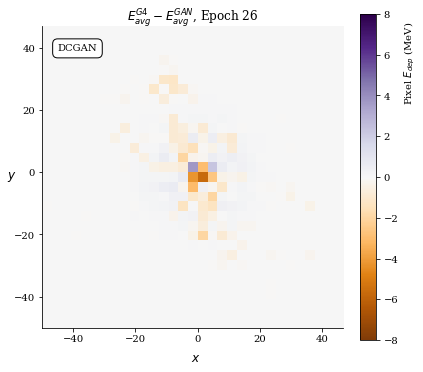

[26/50][0/1500] Loss_D: 0.0536 Loss_G: 5.7010 D(x): 0.9635 D(G(z)): 0.0035 / 0.0040


Process Process-216:
Process Process-215:
Process Process-213:
Process Process-212:
Process Process-209:
Process Process-210:
Process Process-214:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
Process Process-211:
    self.run()
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/chris/anaconda2/envs/pytorch04/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/chris/anaconda2/en

KeyboardInterrupt: 

In [37]:
iter_range = range(niter)
iter_range = tqdm(iter_range)


#make save directory
# mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/', 
#                      datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")

mydir = os.path.join('/home/chris/Dropbox/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + "/")
#mydir = None
if mydir != None:
    try:
        os.makedirs(mydir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise

   # with open(mydir + 'NetworkInfo.txt', 'w') as f:
     #   print >> f, 'model:', model
    #    print >> f, 'normalization scale:', norm_scale
     #   print >> f, 'image height/width:', imageSize
       # print >> f, 'loss function: Regular GAN'
      #  print >> f, 'batch size:', batchSize
      #  print >> f, 'epochs:', niter
       # print >> f, 'beta:', beta
      #  print >> f, 'gun Energy:', energy
      #  print >> f, 'last activation layer:', last_decode_act
      #  print >> f, 'batch size:', batchSize
      #  print >> f, 'unnormalize loss:', unnormalize_loss
    
    with open(mydir + 'NetworkInfo.txt', 'w') as f:
        f.write( 'generator: ' +  str(netG) + "\n")
        f.write('discriminator: ' +  str(netD) + '\n')
        f.write('normalization scale: ' +  norm_scale + '\n')
        f.write('image height/width: ' + str(imageSize) + '\n')
        f.write('loss function: Regular GAN \n')
        f.write('epochs:' + str(niter) + '\n')
        f.write('batch size:' + str(batchSize) + '\n')


extraD = 1
epochs = []
genx_FWHMs = []
genx_means = []
realx_FWHMs = []
realx_means =  []
for epoch in iter_range:
    if True:

        data_arrs, n_events = make_samples(netG, n_events = 500, real=True, fake=True)
        real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 500,real= True, fake = True)
        genx_FWHM = hist_width(np.sum(data_arrs[1],1))
        realx_FWHM = hist_width(np.sum(data_arrs[0],1))
        genx_mean = np.sum(data_arrs[1],1).mean()
        realx_mean = np.sum(data_arrs[0],1).mean()
        genx_FWHMs.append(genx_FWHM)
        realx_FWHMs.append(realx_FWHM)
        genx_means.append(genx_mean)
        realx_means.append(realx_mean)
        epochs.append(epoch)
        plot_all_metrics(genx_FWHMs, realx_FWHMs, genx_means, realx_means,epochs = epochs, save_dir = mydir)
        plot_avg_both(data_arrs[0],data_arrs[1], n_events, save_dir = mydir,  epoch = epoch)
        plot_avg(data_arrs[1], n_events, save_dir= mydir,  epoch = epoch)
        plot_many(fake_data_array, real=False, save_dir=mydir, epoch = epoch)
        plot_many(real_data_array, real=True, save_dir=mydir, epoch = epoch)
        plot_difference(data_arrs, save_dir = None, epoch = epoch)
    for i, data in enumerate(dataloader,0):
        for j in range(extraD):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))), do it more than generator
            ###########################
            # train with real
            netD.zero_grad()
            real_cpu = data[0].to(device)
            batch_size = real_cpu.size(0)
            label = torch.full((batch_size,), real_label, device=device)

            output = netD(real_cpu)
            real_cpu.requires_grad_()
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, niter, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
#         if i % 500 == 0:
#             vutils.save_image(real_cpu.data,
#                     '%s/real_samples.png' % outf,
#                     normalize=True)
#             fake = netG(fixed_noise)
#             vutils.save_image(fake.detach(),
#                     '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
#                    normalize=True)

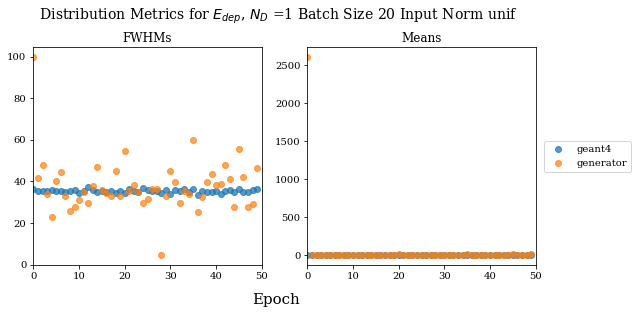

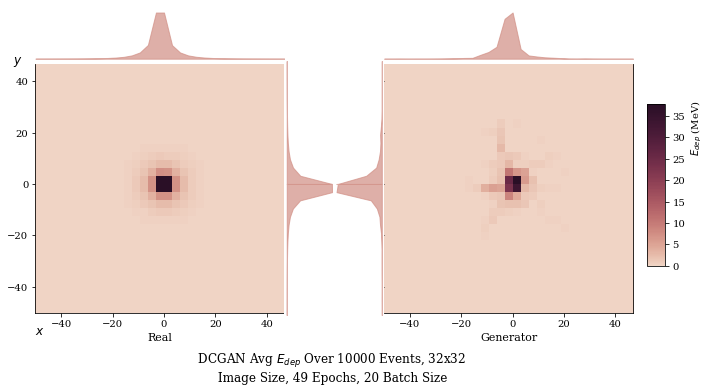

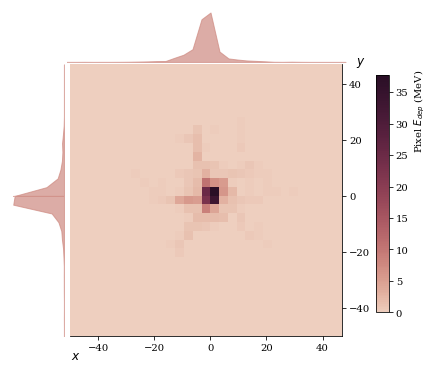

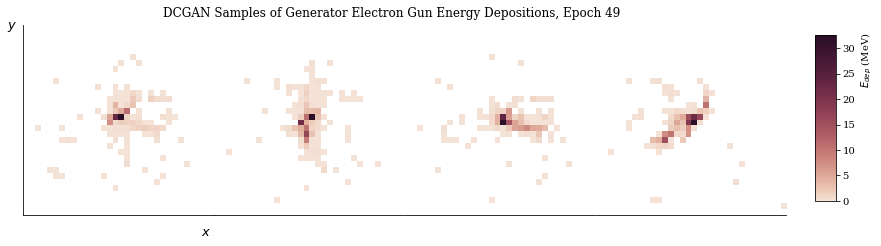

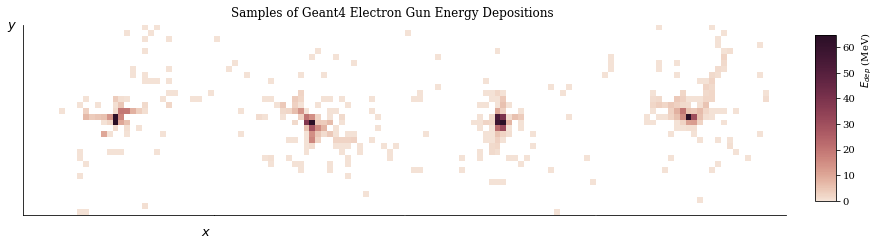

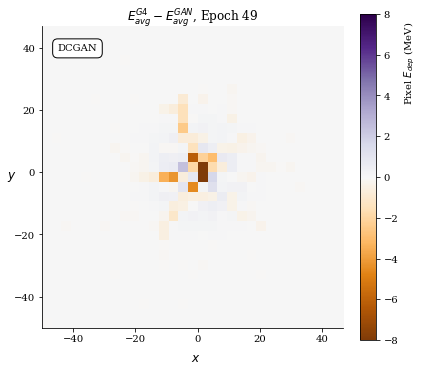

In [116]:
#FAKE
#from mpl_toolkits.axes_grid1 import make_axes_locatable



# test_unnormed, n_events = make_samples(netG,n_events = 500, real=False)
# plot_avg(test_unnormed, n_events = 500, save_dir=None)
# data, n_events = make_samples(netG, n_events = 500, real=True, fake=True)
# plot_difference(data, save_dir = None, epoch = epoch)

data_arrs, n_events = make_samples(netG, n_events = 10000, real=True, fake=True)
real_data_array, fake_data_array = make_stacked_samples(netG, n_events = 10000,real= True, fake = True)
mydir=None
plot_all_metrics(genx_FWHMs, realx_FWHMs, genx_means, realx_means,epochs = epochs, save_dir = mydir)
plot_avg_both(data_arrs[0],data_arrs[1], n_events, save_dir = mydir,  epoch = epoch)
plot_avg(data_arrs[1], n_events, save_dir= mydir,  epoch = epoch)
plot_many(fake_data_array, real=False, save_dir=mydir, epoch = epoch)
plot_many(real_data_array, real=True, save_dir=mydir, epoch = epoch)
plot_difference(data_arrs, save_dir = mydir, epoch = epoch)

/home/chris/anaconda2/envs/pytorch04/lib/python2.7/site-packages/ipykernel_launcher.py:339: RuntimeWarning: invalid value encountered in less


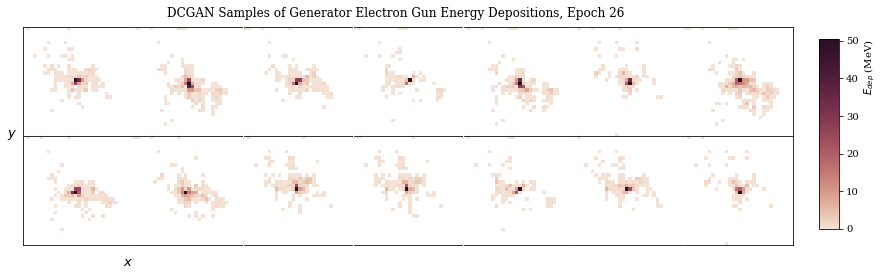

In [39]:
plot_many(fake_data_array, rows=2, columns=7, real=False, save_dir=mydir, epoch=epoch)#plot_samples()

In [229]:
test = np.squeeze(image_array)
for i in range(test.shape[0]):
    if np.isnan(test[i].max()) ==True:
        print(i)

In [213]:
#REAL
plt.rc('font', family='serif')
many_samples = True
n_events = 5000
#make single samples for both real and fake. then make many samples and average if many_samples = True

#real
idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
real_image = image_array[idx][0]

#fake
noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake = netG(noise)
fake_image = fake.to('cpu').detach().numpy()[0][0]
test_unnormed =  arctanh_unnormalize(fake_image, scale)

if many_samples == True:
    for i in range(n_events):
        idx = np.random.randint(low = 0, high = image_array.shape[0], size =1)[0]
        real_image += image_array[idx][0]
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        fake_image = fake.to('cpu').detach().numpy()[0][0]
        test_unnormed +=  arctanh_unnormalize(fake_image, scale)

real_image = real_image / n_events
test_unnormed = test_unnormed / n_events
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(9, 6), sharex=True, sharey=True)
xran = (-50,50)
yran = (-50,50)
extent = xran + yran





real_image[real_image < 0.0] = np.nan
cmap = sns.cubehelix_palette(dark = 0.4, light=0.915, gamma = 2.5, hue = 1, start =0, as_cmap=True)
#plt.hist2d(fake.to('cpu').detach().numpy()[0][0][:,0], fake.to('cpu').detach().numpy()[0][0][:,1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
im = ax1.imshow(real_image, vmin = 0, extent=extent, origin='lower', cmap=cmap)




ax1.set_title("Real")
#cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
#cbar.set_label(r'Pixel $E_{dep}$ (MeV)', y=0.85)
        
test_unnormed[test_unnormed < 0.0] = np.nan
im = ax2.imshow(test_unnormed, vmin = 0, extent=extent, origin='lower', cmap=cmap)
ax2.set_title("Generator")

fig.tight_layout(rect=[0, 0, .9, 1])
cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label(r'$E_{dep}$ (MeV)', y =0.85)
fig.subplots_adjust(wspace=0.1, hspace=0)
fig.suptitle(r" DCGAN Avg $E_{dep}$ Over " + str(n_events) + " Events, "
             + str(imageSize) + "x" +str(imageSize) + " Image Size, " + str(niter) 
             + " Epochs, " + str(batchSize) + " Batch Size", x = 0.5, y = 0.9)
plt.show()

TypeError: unsupported operand type(s) for /: 'int' and 'list'

In [412]:
mydir = os.path.join('/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/', 
                     datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + '/')
print(mydir)
try:
    os.makedirs(mydir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

/home/chris/Documents/MPhilProjects/ForViewing/plots/Geant4/SingleLayerEGun/DCGAN/2018-05-16_17-09-05/


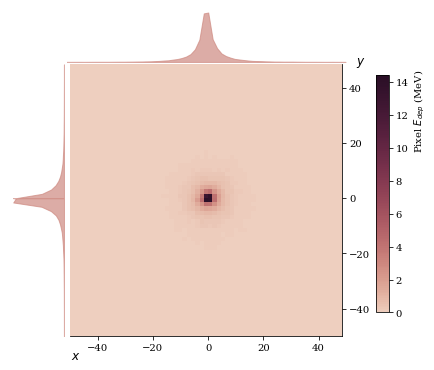

In [195]:
test_unnormed, n_events = make_samples(netG,n_events = 500, real=True, fake = True)
plot_avg(test_unnormed[0], n_events = 500, save_dir=None)

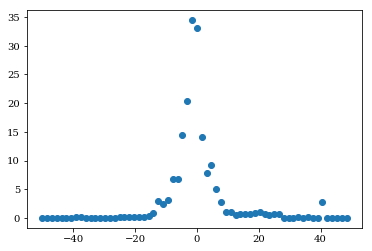

In [35]:
x = np.linspace(-50,50, 64)
t = np.arange(-50,50, 100/float(imageSize))
plt.scatter(t,np.sum(test_unnormed,1) )

In [37]:


print(hist_width(np.sum(test_unnormed[0], 0)))
print(hist_width(np.sum(test_unnormed[1], 0)))

0.0
0.0
